## Low-Level Sound Descriptors

Low-level sound descriptors are closely related to the signal characteristics of a sound. 

They are used to describe the signal at different levels of granularity. 

There are at least three levels of extraction granularity from the signal: at any point in the signal (**instantaneous**), in small arbitrary regions (i.e., frames), and longer pre-segmented regions (e.g. global). 

Low-level descriptors are used to extract information from the signal that can be used to describe the sound. 

They are used in many applications, including music information retrieval, speech recognition, and audio signal processing



In [35]:
import os
import numpy as np
import matplotlib
from  matplotlib import pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
matplotlib #inline

<module 'matplotlib' from 'c:\\Users\\mpspm\\.conda\\envs\\SAM\\lib\\site-packages\\matplotlib\\__init__.py'>

Here we have some helper code for this assignment.

In [36]:
def stft_basic(x, w, H=8, only_positive_frequencies=False):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)

    Notebook: C2/C2_STFT-Basic.ipynb

    Args:
        x: Signal to be transformed
        w: Window function
        H: Hopsize
        only_positive_frequencies: Return only positive frequency part of spectrum (non-invertible)

    Returns:
        X: The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int) + 1
    X = np.zeros((N, M), dtype='complex')
    for m in range(M):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win
        
    if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
    return X

def compute_stft(x, fs):
    # STFT Parameterisation and computation
    H = 1024
    N = 2048
    w = np.hanning(N)
    X = stft_basic(x, w, H)
    Y = np.abs(X) ** 2
    eps = np.finfo(float).eps
    Y_db = 10 * np.log10(Y + eps)

    T_coef = np.arange(X.shape[1]) * H / fs
    F_coef = np.arange(X.shape[0]) * fs / N
    left = min(T_coef)
    right = max(T_coef) + N / fs
    lower = min(F_coef)
    upper = max(F_coef)
    return left, right, lower, upper

def log_attack_time(y, fs, start=0.2, end=0.9):
    # adapted from http://www.ifs.tuwien.ac.at/~schindler/lectures/MIR_Feature_Extraction.html
    th0 = start * max(y)
    th1 = end * max(y)
    th0_cross = np.diff(y > th0, prepend=False)
    th1_cross = np.diff(y > th1, prepend=False)

    # Get the index where the signal cross the threshold
    index0 = np.argwhere(th0_cross)[0,0]
    index1 = np.argwhere(th1_cross)[0,0]
    
    # Convert index to time
    T0 = index0 / fs
    T1 = index1 / fs

    # Compute Log Attack Time
    attack_time = T1 - T0
    log_attack_time = np.log10(attack_time)
    return log_attack_time


def effective_duration(y, fs, threshold=0.05):
    rms = librosa.feature.rms(y=y)
    th = threshold*max(rms[0])
    samples_above = np.count_nonzero(rms > th)
    effective_duration = samples_above/len(rms[0])*librosa.get_duration(y=y, sr=fs)
    return effective_duration

def temporal_centroid(y, fs):
    """
    adapted from https://www.audiocontentanalysis.org/code/audio-features/spectral-centroid-2/
    computes the temporal centroid from the waveform
    """
    norm = y.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1
    vtc = np.dot(np.arange(0, y.shape[0]), y) / norm
    # convert from index to seconds
    vtc = vtc / fs
    vtc = np.squeeze(vtc)
    return vtc


def spectral_flux(y):
    """
    adapted from https://www.audiocontentanalysis.org/code/audio-features/spectral-flux-2/
    computes the spectral flux from the magnitude spectrum
    """
    mag_fft = np.abs(librosa.stft(y))
    isSpectrum = mag_fft.ndim == 1
    if isSpectrum:
        mag_fft = np.expand_dims(mag_fft, axis=1)
    # difference spectrum (set first diff to zero)
    mag_fft = np.c_[mag_fft[:, 0], mag_fft]
    afDeltaX = np.diff(mag_fft, 1, axis=1)
    # flux
    vsf = np.sqrt((afDeltaX**2).sum(axis=0)) / mag_fft.shape[0]
    vsf = np.expand_dims(vsf, axis=0)
    return vsf

### Time-domain:
   
#### Instantaneous

**RMS/Energy**

`rms = librosa.feature.rms(x)`

**Zero Crossing Rate** 
> The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive. Periodic sounds tend to have a small value of it, while noisy sounds tend to have a high value of it.

`zcr = librosa.feature.zero_crossing_rate(x)`

#### Global
     
**Log-attack time**
> The attack time is defined as the time duration from when the sound becomes perceptually audible to when it reaches its maximum intensity. The start of the attack is estimated as the point where the signal envelope reaches a threshold (by default 20%) of its maximum value (in order to account for possible noise presence), and the end of the attack is estimated as as the point where the signal envelope has reached a threshold (by default 90%) of its maximum value, in order to account for the possibility that the max value occurres after the logAttack, as in trumpet sounds.      

`lat = log_attack_time(x, fs, start=0.2, end=0.9)`

**Temporal centroid**
>  Temporal centroid is the temporal correspondent of the spectral centroid: it's the center of gravity of the energy envelope. It has been proved to be one perceptually important descriptor.

`tc= temporal_centroid(y, fs)`

**Effective duration** 
> The effective duration is a measure of the time the signal is perceptually meaningful. It is approximated by the time the energy envelop is above a given threshold.

`ed = effective_duration(x, fs, threshold=0.05)`

### Frequency-domain:

#### Instantaneous

**Spectral centroid**
> The spectral centroid indicates where the center of mass (or gravity) of the spectrum is located. Perceptually, it has  a robust connection with the impression of brightness of a sound.

`spec_cent = librosa.feature.spectral_centroid(x, sr=fs)`

**Spectral spread / spectral bandwidth**
> It is a measure of how the spectrum is distributed around the spectral centroid and it defines the variance from the spectral centroid.

`spec_bw = librosa.feature.spectral_bandwidth(x, sr=fs)`

**Spectral variation / spectral flux**
> Spectral flux is a measure of how quickly the power spectrum of a signal is changing, calculated by comparing the power spectrum for one frame against the power spectrum from the previous frame

`spec_flux = spectral_flux(x)`

**Spectral flatness** 
> Spectral flatness is a way to quantify how close a sound is to being noise or a tone. A high spectral flatness (approaching 1.0 for white noise) indicates that the spectrum has a similar amount of power in all spectral bands.

`spectral_flatness = librosa.feature.spectral_flatness(y=x)`


## Example

As an illustrative example, we consider a recording of a C-major scale played on a piano. 

<img src="./data/example/FMP_C2_F10a.png" width="300px" align="left" alt="C0">

<br clear="all" />

<audio src="./data/example/FMP_C2_F10.wav" type="audio/mpeg" controls="controls"></audio>

In the following figure, the spectrogram representation of the recording is shown, where the time and frequency axes are labeled in a physically meaningful way. Furthermore, the spectrogram is also shown using a logarithmic dB scale (to enhance small sound components that may still be perceptually relevant).

The spectrogram reveals the frequency information of the played notes over time. For each note, one can observe horizontal lines that are stacked on top of each other. These equally spaced lines correspond to the partials, the integer multiples of the fundamental frequency of a note. Obviously, the higher partials contain less and less of the signal's energy. Furthermore, the decay of each note over time is reflected by the fading out of the horizontal lines.


<!-- <img src="./data/FMP_C2_F10.png" width="500px" align="middle" alt="C0"> -->

Now we load the sound file and plot the waveform (time-domain) as well as the spectrogram (time-frequency).

Note: The spectrogram reveals the frequency information of the played notes over time. For each note, one can observe horizontal lines that are stacked on top of each other. These equally spaced lines correspond to the partials, the integer multiples of the fundamental frequency of a note. Obviously, the higher partials contain less and less of the signal's energy. Furthermore, the decay of each note over time is reflected by the fading out of the horizontal lines.

In [37]:
fn_wav = os.path.join('.', 'data','example', 'FMP_C2_F10.wav')
x, fs = librosa.load(fn_wav)

And we plot the waveform and some time-based sound descriptors:

lat:0.3841733255983914
ed:7.28042328042328
tc:5.156217575073242


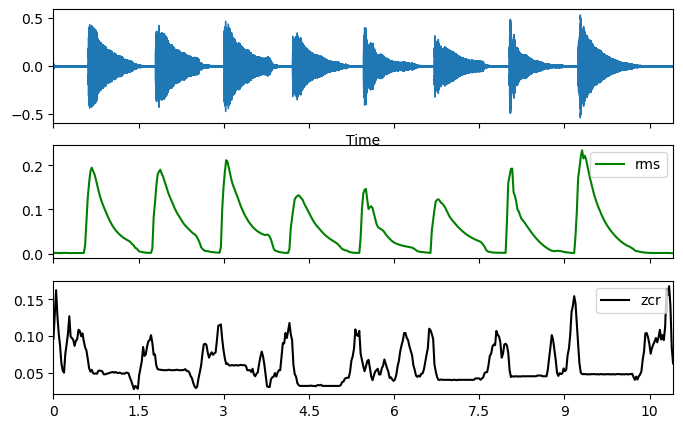

In [38]:
# Figure
fig_time,axs_time = plt.subplots(3,1, figsize=(8, 5), sharex=True)

t = np.arange(len(x)) / fs
librosa.display.waveshow(x, sr=fs, ax=axs_time[0])
axs_time[0].set_xlim([min(t), max(t)])

# Add the rms (from librosa)
rms = librosa.feature.rms(y=x)
times = librosa.times_like(rms) # times will be the same for all features
axs_time[1].plot(times, rms.T, label='rms', color='g')
axs_time[1].legend(loc='upper right')

zcr = librosa.feature.zero_crossing_rate(x)
axs_time[2].plot(times, zcr.T, label='zcr', color='k')
axs_time[2].legend(loc='upper right')

lat = log_attack_time(x, fs, start=0.2, end=0.9)
print(f'lat:{lat}')

ed= effective_duration(x, fs, threshold=0.05)
print(f'ed:{ed}')

tc = temporal_centroid(x, fs)
print(f'tc:{tc}')

Now we plot the spectrogram and some frequency-based sound descriptors.

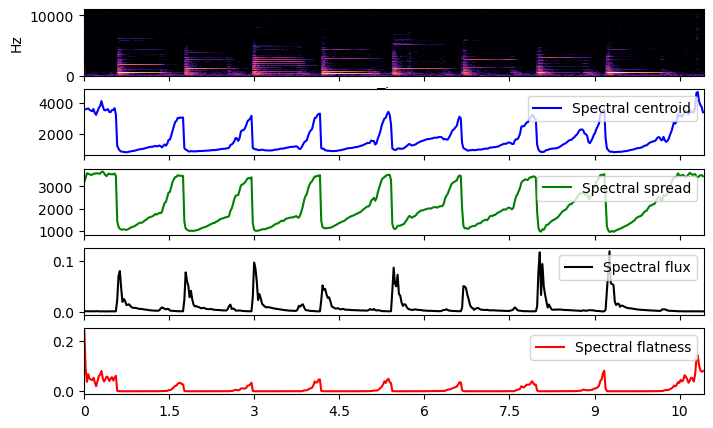

In [39]:
# Figure
fig_freq,axs_freq = plt.subplots(5,1, figsize=(8, 5), sharex=True)

D = librosa.stft(x)  # STFT
# Get Spectrogram in dB
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axs_freq[0]) 

# Add the spectral centroid (from librosa)
spec_cent = librosa.feature.spectral_centroid(y=x, sr=fs)
times = librosa.times_like(spec_cent)
axs_freq[1].plot(times, spec_cent.T, label='Spectral centroid', color='b')
axs_freq[1].legend(loc='upper right')

spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=fs)
axs_freq[2].plot(times, spec_bw.T, label='Spectral spread', color='g')
axs_freq[2].legend(loc='upper right')


spec_flux = spectral_flux(x)
axs_freq[3].plot(times, spec_flux.T, label='Spectral flux', color='k')
axs_freq[3].legend(loc='upper right')
      
spec_flat = librosa.feature.spectral_flatness(y=x)
axs_freq[4].plot(times, spec_flat.T, label='Spectral flatness', color='r')
axs_freq[4].legend(loc='upper right')


# Assignment

### Goal
The goal of this assignment is to accomplish a step-by-step audio classification system.
While pursuing this goal, we will be able to understand, implement and evaluate a simple set of low-level audio descriptors and analyse their distribution over a collection of sounds.  
The chosen sounds are samples of isolated notes from musical instruments, and we will be evaluating the classification over 2 dimensions: 
* Instrument excitation: *percussive* vs *non-percussive*. These are found by the existence of `pizz` on the filename
* Instrument type: the name of the instrument (e.g. accordion, flute, cello, etc.). The first letters of the filename give the name of the instrument.





## Task 1
### Sound Descriptors
Please review briefly the paper by Peeters (Peeters, 2004) [“A large set of audio features for sound description (similarity and classification) in the cuidado project"](http://recherche.ircam.fr/anasyn/peeters/ARTICLES/Peeters_2003_cuidadoaudiofeatures.pdf), to make sure that you understand the following descriptors:

#### Time-domain:
**Instantaneous**
1. RMS/Energy; 2. Zero Crossing Rate 
**Global**
3. Log-attack time; 4. Temporal centroid; 5. Effective duration 

#### Frequency-domain:
**Instantaneous**
6. Spectral centroid; 7. Spectral spread; 8. Spectral variation / spectral flux; 9. Spectral flatness 

Please pick 2 descriptors by group (one from time-domain and another from frequency-domain), depart from the formula and explain the theoretical expected values for a *sinusoid* and *white noise*. 



## Task 1 answer

Time-domain:
* RMS/Energy: 
The RMS/Energy descriptor is the energy (loudness) of a sound in a given moment, that energy is directly related to the amplitude of the corresponding sine wave.
    * Sinusoid: assuming the sound wave keeps the same amplitude over time, the RMS graph would look like a horizontal line. If, on the other hand, the sound wave amplitude decreases steadily, aka the sound becomes quieter, the RMS graph will be a straight line with a negative incline 
    * white noise: The RMS graph is a near horizontal line at y=(energy of the sound)
    
* Spectral flatness
The spectral flatness is a value between 0 and 1 that quantifies how close a sound is to being a tone or a noise, respectively
    * Sinusoid: : Assuming the sound wave keeps the same amplitude over time, the Spectral flatness graph would look like a horizontal line at y~0. If, on the other hand, the sound wave amplitude decreases steadily, aka the sound becomes quieter, the RMS graph will be a curve from ~0 to ~1, it reaches ~1 when the sound wave amplitude is near 0.
    * white noise: The Spectral flatness graph is a horizontal line near y~1

## Task 2

### Exploratory Data Analysis

Implement a function to obtain, for a given audio file, the mentioned set of instantaneous descriptors (1,2,6-9), the mentioned set of global descriptors (3,4,5), as well as statistics of the previous instantaneous (1,2,6-9) descriptors (e.g. mean, standard deviation, min, max).

2.1. Create plots to visualize the extracted instantaneous low-level descriptors and study their evolution for a small set of instrument samples (e.g. percussive, string, wind instrument). 

2.2. Study the values of these descriptors for the previous instrumental samples and analyse how they represent the following aspects: percussive/non-percussive sounds, sustained/non sustained, low-pitch/high pitch, and instrument.
In order to do that, you can build 2-D plots visualizing the values of 2 descriptors for the different samples, e.g.:
-	Spectral Flux mean vs Spectral Spread mean
-	Spectral Flux mean vs Spectral Flatness
-	Spectral Centroid mean vs Zero Crossing Rate mean
-	Temporal Centroid vs Log Attack Time.

2.3. Do you think these descriptors are enough to accomplish both classifications or you feel the need for more descriptors? (You may come to this question again after you have tried the classification )

In [40]:
from IPython.display import Audio
import IPython

vln_pizz_wav = os.path.join('.', 'data','sounds', 'vln_e_C5_12_pizz.wav')
cbs_pizz_wav = os.path.join('.', 'data','sounds', 'cbs_g_C2_12_pizz.wav')

vln_wav = os.path.join('.', 'data','sounds', 'vln_a_G4_12.wav')
cbs_wav = os.path.join('.', 'data','sounds', 'cbs_g_G3_12.wav')

trp_wav = os.path.join('.', 'data', 'sounds', 'trp_G4_12.wav')
sax_wav = os.path.join('.', 'data', 'sounds', 'sax_G4_12.wav')

vln_pizz_wave, vln_pizz_fs = librosa.load(vln_pizz_wav)
cbs_pizz_wave, cbs_pizz_fs = librosa.load(cbs_pizz_wav)

vln_wave, vln_fs = librosa.load(vln_wav)
cbs_wave, cbs_fs = librosa.load(cbs_wav)

trp_wave, trp_fs = librosa.load(trp_wav)
sax_wave, sax_fs = librosa.load(sax_wav)

IPython.display.display(Audio(data=vln_pizz_wave, rate=vln_pizz_fs))
IPython.display.display(Audio(data=cbs_pizz_wave, rate=cbs_pizz_fs))

IPython.display.display(Audio(data=vln_wave, rate=vln_fs))
IPython.display.display(Audio(data=cbs_wave, rate=cbs_fs))

IPython.display.display(Audio(data=trp_wave, rate=trp_fs))
IPython.display.display(Audio(data=sax_wave, rate=sax_fs))

#### Dictionary to save descriptors

In [41]:
descriptorsDict = {
    "name": [],
    "type": [],
    "isPizz": [],
    "rmsMean": [],
    "rmsStd": [],
    "rmsMax": [],
    "rmsMin": [],
    "zcrMean": [],
    "zcrStd": [],
    "zcrMax": [],
    "zcrMin": [],
    "lat": [],
    "tc": [],
    "ed": [],
    "specCentMean": [],
    "specCentStd": [],
    "specCentMax": [],
    "specCentMin": [],
    "specBwMean": [],
    "specBwStd": [],
    "specBwMax": [],
    "specBwMin": [],
    "specFluxMean": [],
    "specFluxStd": [],
    "specFluxMax": [],
    "specFluxMin": [],
    "specFlatMean": [],
    "specFlatStd": [],
    "specFlatMax": [],
    "specFlatMin": [],
}

#### Basic function to get descriptors and plots

In [42]:
def basic_plots(name, descriptorsDict, toPlot=True):
    fileName = os.path.join('.', 'data','sounds', name)
    wave, fs = librosa.load(fileName)

    rms = librosa.feature.rms(y=wave)
    zcr = librosa.feature.zero_crossing_rate(wave)
    spec_cent = librosa.feature.spectral_centroid(y=wave, sr=fs)
    spec_bw = librosa.feature.spectral_bandwidth(y=wave, sr=fs)
    spec_flux = spectral_flux(wave)
    spec_flat = librosa.feature.spectral_flatness(y=wave)

    if(toPlot):
        # Figure
        fig_time, axs_time = plt.subplots(3,1, figsize=(8, 5), sharex=True)

        t = np.arange(len(wave)) / fs
        librosa.display.waveshow(wave, sr=fs, ax=axs_time[0])
        axs_time[0].set_xlim([min(t), max(t)])

        # Add the rms (from librosa)
        times = librosa.times_like(rms) # times will be the same for all features
        axs_time[1].plot(times, rms.T, label='rms', color='g')
        axs_time[1].legend(loc='upper right')

        # ZCR
        axs_time[2].plot(times, zcr.T, label='zcr', color='k')
        axs_time[2].legend(loc='upper right')

        # Figure
        fig_freq,axs_freq = plt.subplots(5,1, figsize=(8, 5), sharex=True)

        D = librosa.stft(wave)  # STFT
        # Get Spectrogram in dB
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axs_freq[0]) 

        # Add the spectral centroid (from librosa)
        times = librosa.times_like(spec_cent)
        axs_freq[1].plot(times, spec_cent.T, label='Spectral centroid', color='b')
        axs_freq[1].legend(loc='upper right')

        axs_freq[2].plot(times, spec_bw.T, label='Spectral spread', color='g')
        axs_freq[2].legend(loc='upper right')

        axs_freq[3].plot(times, spec_flux.T, label='Spectral flux', color='k')
        axs_freq[3].legend(loc='upper right')

        axs_freq[4].plot(times, spec_flat.T, label='Spectral flatness', color='r')
        axs_freq[4].legend(loc='upper right')


    # add info to dict
    descriptorsDict["name"].append(name)
    descriptorsDict["type"].append(name[0:3])
    descriptorsDict["isPizz"].append("pizz" in name)

    rms_average = np.average(rms)
    rms_std = np.std(rms)
    rms_max = np.max(rms)
    rms_min = np.min(rms)

    descriptorsDict["rmsMean"].append(rms_average)
    descriptorsDict["rmsStd"].append(rms_std)
    descriptorsDict["rmsMax"].append(rms_max)
    descriptorsDict["rmsMin"].append(rms_min)
    
    zcr_average = np.average(zcr)
    zcr_std = np.std(zcr)
    zcr_max = np.max(rms)
    zcr_min = np.min(rms)

    descriptorsDict["zcrMean"].append(zcr_average)
    descriptorsDict["zcrStd"].append(zcr_std)
    descriptorsDict["zcrMax"].append(zcr_max)
    descriptorsDict["zcrMin"].append(zcr_min)

    spec_cent_average = np.average(spec_cent)
    spec_cent_std = np.std(spec_cent)
    spec_cent_max = np.max(spec_cent)
    spec_cent_min = np.min(spec_cent)

    descriptorsDict["specCentMean"].append(spec_cent_average)
    descriptorsDict["specCentStd"].append(spec_cent_std)
    descriptorsDict["specCentMax"].append(spec_cent_max)
    descriptorsDict["specCentMin"].append(spec_cent_min)

    spec_bw_average = np.average(spec_bw)
    spec_bw_std = np.std(spec_bw)
    spec_bw_max = np.max(spec_bw)
    spec_bw_min = np.min(spec_bw)

    descriptorsDict["specBwMean"].append(spec_bw_average)
    descriptorsDict["specBwStd"].append(spec_bw_std)
    descriptorsDict["specBwMax"].append(spec_bw_max)
    descriptorsDict["specBwMin"].append(spec_bw_min)

    spec_flux_average = np.average(spec_flux)
    spec_flux_std = np.std(spec_flux)
    spec_flux_max = np.max(spec_flux)
    spec_flux_min = np.min(spec_flux)

    descriptorsDict["specFluxMean"].append(spec_flux_average)
    descriptorsDict["specFluxStd"].append(spec_flux_std)
    descriptorsDict["specFluxMax"].append(spec_flux_max)
    descriptorsDict["specFluxMin"].append(spec_flux_min)

    spec_flat_average = np.average(spec_flat)
    spec_flat_std = np.std(spec_flat)
    spec_flat_max = np.max(spec_flat)
    spec_flat_min = np.min(spec_flat)
    
    descriptorsDict["specFlatMean"].append(spec_flat_average)
    descriptorsDict["specFlatStd"].append(spec_flat_std)
    descriptorsDict["specFlatMax"].append(spec_flat_max)
    descriptorsDict["specFlatMin"].append(spec_flat_min)

    lat = log_attack_time(wave, fs, start=0.01, end=0.99)
    descriptorsDict["lat"].append(lat)
    
    ed = effective_duration(wave, fs, threshold=0.05)
    descriptorsDict["ed"].append(ed)

    tc = temporal_centroid(wave, fs)
    descriptorsDict["tc"].append(tc)
    if(toPlot):
        print(f'effective duration:{ed}')
        print(f'log attack time:{lat}')
        print(f'temporal centroid:{tc}')

#### Apply previous function to selected files

effective duration:0.7185921744584358
log attack time:-1.4800857336834015
temporal centroid:0.544092059135437


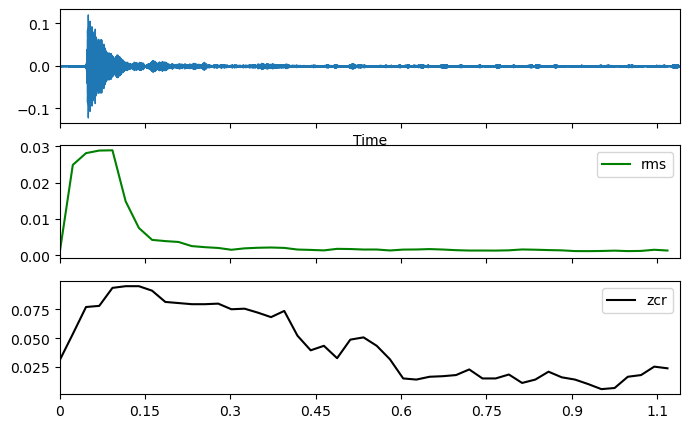

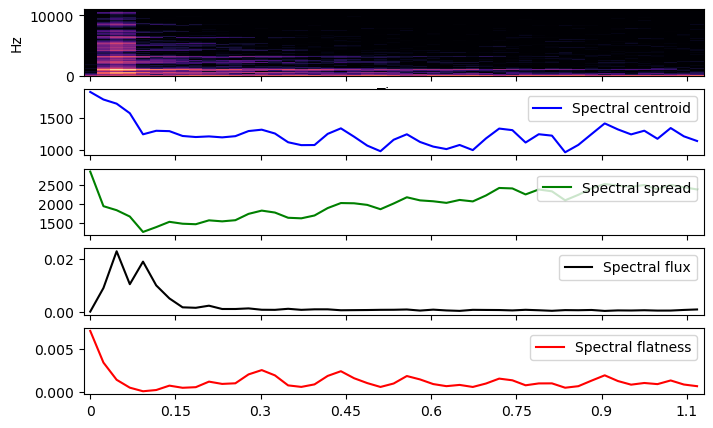

In [43]:
files = [
'vln_e_C5_12_pizz.wav','cbs_g_C2_12_pizz.wav','vln_a_G4_12.wav',
'cbs_g_G3_12.wav', 'trp_G4_12.wav','sax_G4_12.wav']

basic_plots(files[0], descriptorsDict, toPlot=True)

effective duration:2.5463619365875005
log attack time:-1.7069206974504918
temporal centroid:11.932703018188477


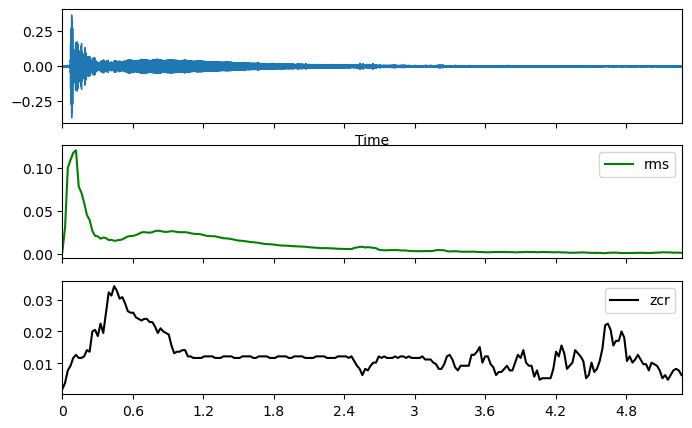

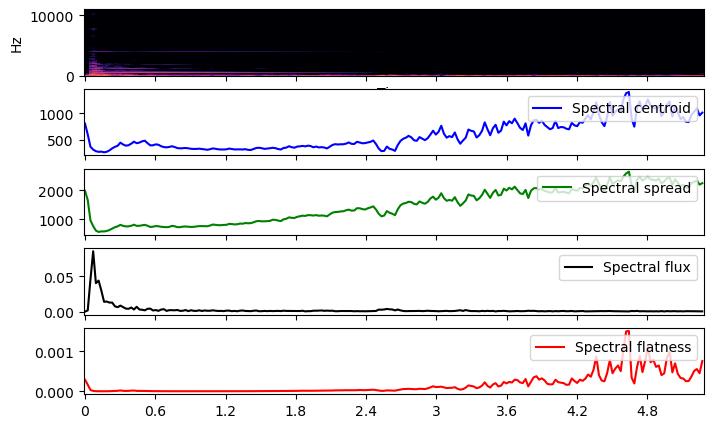

In [44]:
basic_plots(files[1], descriptorsDict, toPlot=True)

effective duration:9.45185766614338
log attack time:0.6425026541274155
temporal centroid:3.565584182739258


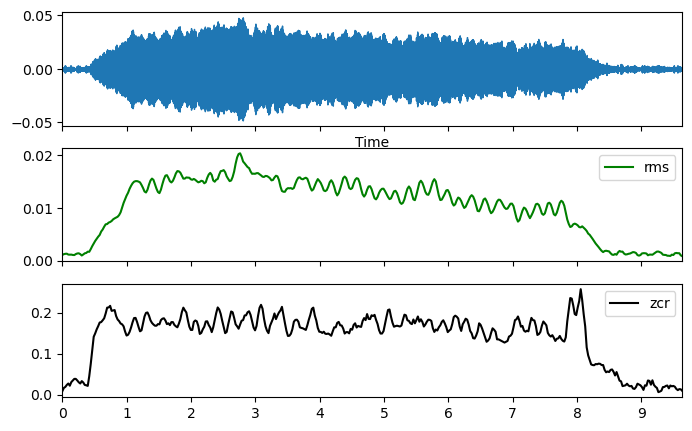

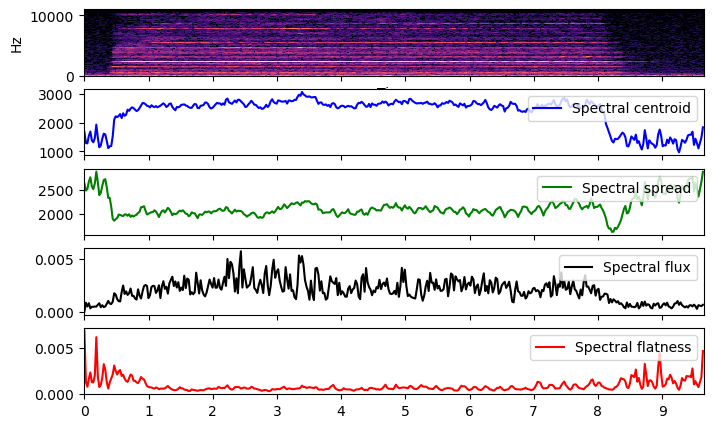

In [45]:
basic_plots(files[2], descriptorsDict, toPlot=True)

effective duration:3.612934662236988
log attack time:-0.06925074454017749
temporal centroid:3.7473607063293457


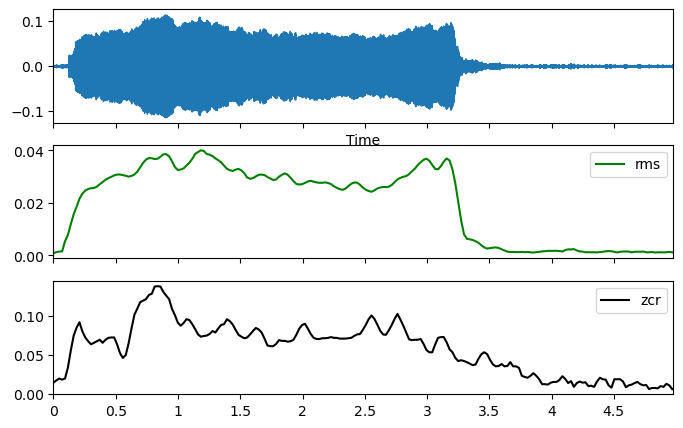

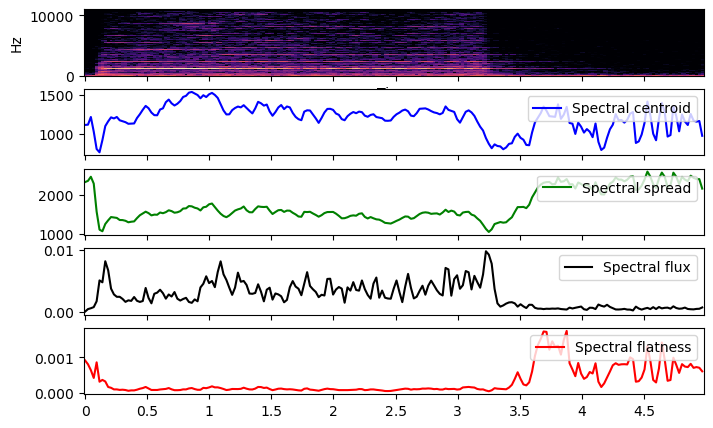

In [46]:
basic_plots(files[3], descriptorsDict, toPlot=True)

effective duration:6.209705215419501
log attack time:0.1316375743239404
temporal centroid:7.90537691116333


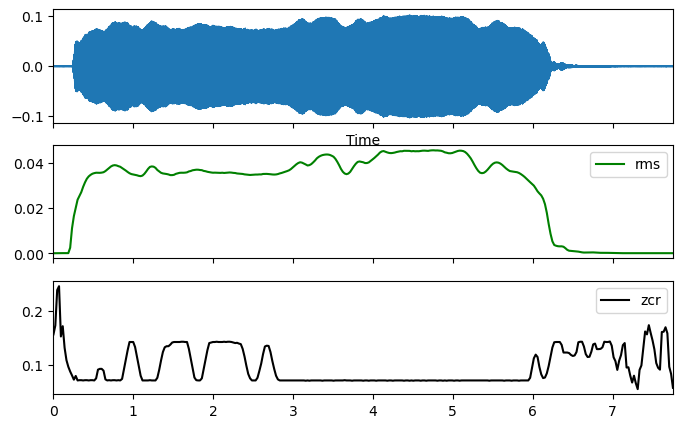

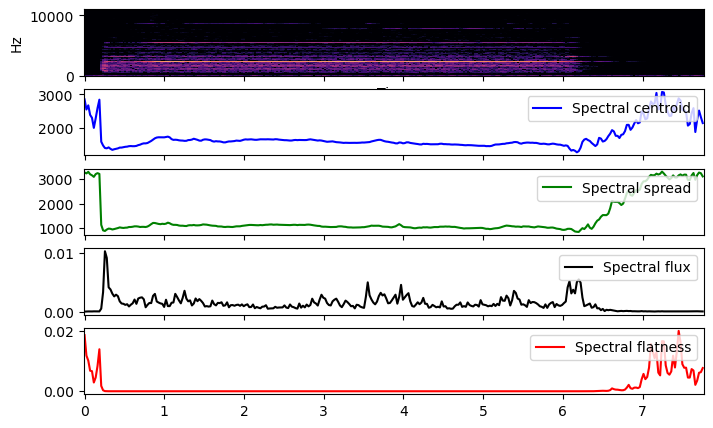

In [47]:
basic_plots(files[4], descriptorsDict, toPlot=True)

effective duration:10.432212532590128
log attack time:0.5611879503829972
temporal centroid:3.3182153701782227


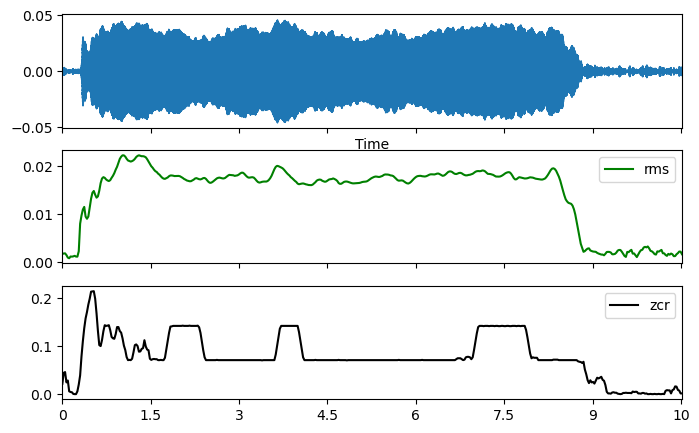

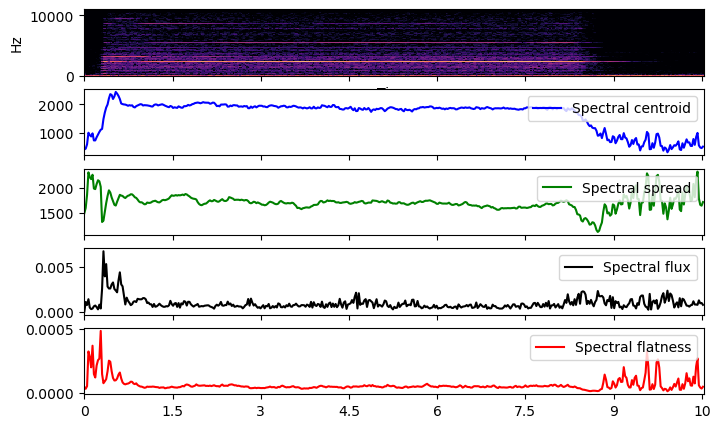

In [48]:
basic_plots(files[5], descriptorsDict, toPlot=True)

#### Converto to dataframe

In [49]:
import pandas as pd

descriptorsDf = pd.DataFrame.from_dict(descriptorsDict)
display(descriptorsDf)

name type  isPizz   rmsMean    rmsStd    rmsMax    rmsMin  \
0  vln_e_C5_12_pizz.wav  vln    True  0.004351  0.007453  0.028905  0.000589   
1  cbs_g_C2_12_pizz.wav  cbs    True  0.011676  0.017423  0.119929  0.000825   
2       vln_a_G4_12.wav  vln   False  0.010467  0.005329  0.020362  0.000822   
3       cbs_g_G3_12.wav  cbs   False  0.019962  0.014279  0.040043  0.000796   
4         trp_G4_12.wav  trp   False  0.029288  0.016377  0.045727  0.000035   
5         sax_G4_12.wav  sax   False  0.014415  0.006439  0.022185  0.000784   

    zcrMean    zcrStd    zcrMax  ...    specBwMax    specBwMin specFluxMean  \
0  0.043852  0.029426  0.028905  ...  2856.052579  1252.011087     0.002219   
1  0.012781  0.005483  0.119929  ...  2647.510331   571.219462     0.002491   
2  0.143910  0.059345  0.020362  ...  2886.402011  1624.886802     0.002030   
3  0.058696  0.032948  0.040043  ...  2597.623903  1051.130000     0.002618   
4  0.095863  0.032566  0.045727  ...  3295.127138   850.890971     0.001298   
5  0.078564  0.044733  0.022185  ...  2336.523911  1116.769821     0.000908   

   specFluxStd  specFluxMax  specFluxMin  specFlatMean  specFlatStd  \
0     0.004572     0.022820          0.0      0.001262     0.001075   
1     0.007817     0.085896          0.0      0.000172     0.000259   
2     0.001037     0.005733          0.0      0.000854     0.000703   
3     0.002003     0.009720          0.0      0.000331     0.000382   
4     0.001191     0.010221          0.0      0.001190     0.003340   
5     0.000657     0.006804          0.0      0.000061     0.000050   

   specFlatMax  specFlatMin  
0     0.007143     0.000075  
1     0.001513     0.000002  
2     0.006840     0.000249  
3     0.001746     0.000049  
4     0.020041     0.000005  
5     0.000487     0.000011  

[6 rows x 30 columns]

#### Example plots as suggested

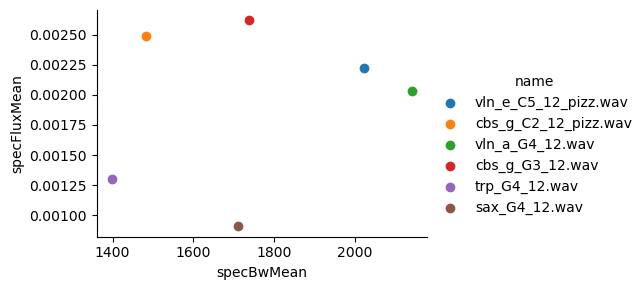

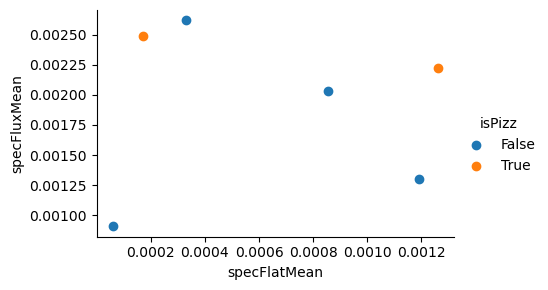

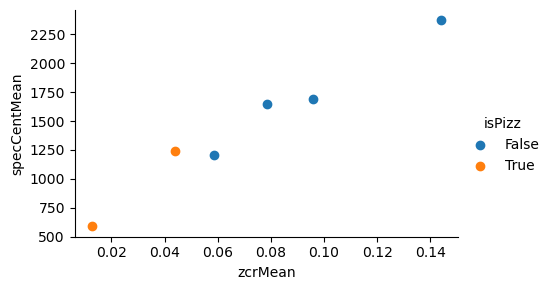

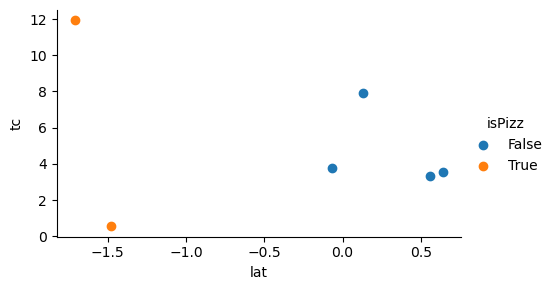

In [50]:
import seaborn as sns

fg = sns.FacetGrid(data=descriptorsDf, hue='name', aspect=1.61)
fg.map(matplotlib.pyplot.scatter, 'specBwMean', 'specFluxMean').add_legend()
plt.show()

fg = sns.FacetGrid(data=descriptorsDf, hue='isPizz', aspect=1.61)
fg.map(matplotlib.pyplot.scatter, 'specFlatMean', 'specFluxMean').add_legend()
plt.show()

fg = sns.FacetGrid(data=descriptorsDf, hue='isPizz', aspect=1.61)
fg.map(matplotlib.pyplot.scatter, 'zcrMean', 'specCentMean').add_legend()
plt.show()

fg = sns.FacetGrid(data=descriptorsDf, hue='isPizz', aspect=1.61)
fg.map(matplotlib.pyplot.scatter, 'lat', 'tc').add_legend()
plt.show()

#### Extract most influencial descriptors on Pitch based on correlation matrix

In [51]:
descriptorsDf.corr().iloc[0]

C:\Users\mpspm\AppData\Local\Temp\ipykernel_13548\2835308761.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  descriptorsDf.corr().iloc[0]


isPizz          1.000000
rmsMean        -0.628021
rmsStd          0.174958
rmsMax          0.583585
rmsMin          0.162872
zcrMean        -0.751745
zcrStd         -0.721219
zcrMax          0.583585
zcrMin          0.162872
lat            -0.963561
ed             -0.769517
specCentMean   -0.700899
specCentStd    -0.515051
specCentMax    -0.610191
specCentMin    -0.280858
specBwMean      0.008557
specBwStd       0.262639
specBwMax      -0.043070
specBwMin      -0.359841
specFluxMean    0.485746
specFluxStd     0.917073
specFluxMax     0.766316
specFluxMin          NaN
specFlatMean    0.105728
specFlatStd    -0.191683
specFlatMax    -0.208424
specFlatMin    -0.217884
Name: isPizz, dtype: float64

In [52]:
threshold = 0.5
corr_matrix = descriptorsDf.corr()
corr_matrix = corr_matrix.loc[['isPizz']]
corr_matrix = corr_matrix.loc[:, (abs(corr_matrix) > threshold).any()]
display(corr_matrix.head())
columns = corr_matrix.columns

C:\Users\mpspm\AppData\Local\Temp\ipykernel_13548\4267492035.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = descriptorsDf.corr()


isPizz   rmsMean    rmsMax   zcrMean    zcrStd    zcrMax       lat  \
isPizz     1.0 -0.628021  0.583585 -0.751745 -0.721219  0.583585 -0.963561   

              ed  specCentMean  specCentStd  specCentMax  specFluxStd  \
isPizz -0.769517     -0.700899    -0.515051    -0.610191     0.917073   

        specFluxMax  
isPizz     0.766316

In [53]:
print(columns)
descriptorsDf[columns]

Index(['isPizz', 'rmsMean', 'rmsMax', 'zcrMean', 'zcrStd', 'zcrMax', 'lat',
       'ed', 'specCentMean', 'specCentStd', 'specCentMax', 'specFluxStd',
       'specFluxMax'],
      dtype='object')


isPizz   rmsMean    rmsMax   zcrMean    zcrStd    zcrMax       lat  \
0    True  0.004351  0.028905  0.043852  0.029426  0.028905 -1.480086   
1    True  0.011676  0.119929  0.012781  0.005483  0.119929 -1.706921   
2   False  0.010467  0.020362  0.143910  0.059345  0.020362  0.642503   
3   False  0.019962  0.040043  0.058696  0.032948  0.040043 -0.069251   
4   False  0.029288  0.045727  0.095863  0.032566  0.045727  0.131638   
5   False  0.014415  0.022185  0.078564  0.044733  0.022185  0.561188   

          ed  specCentMean  specCentStd  specCentMax  specFluxStd  specFluxMax  
0   0.718592   1243.815134   190.319948  1912.631103     0.004572     0.022820  
1   2.546362    588.631854   279.696859  1405.460669     0.007817     0.085896  
2   9.451858   2372.313446   516.063846  3071.206328     0.001037     0.005733  
3   3.612935   1204.241666   168.062465  1538.145333     0.002003     0.009720  
4   6.209705   1689.965529   353.358099  3075.485025     0.001191     0.010221  
5  10.432213   1648.857123   501.688109  2441.021752     0.000657     0.006804

C:\Users\mpspm\AppData\Local\Temp\ipykernel_13548\3910028961.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(descriptorsDf.index, descriptorsDf[col], c=colors,cmap="bwr_r")


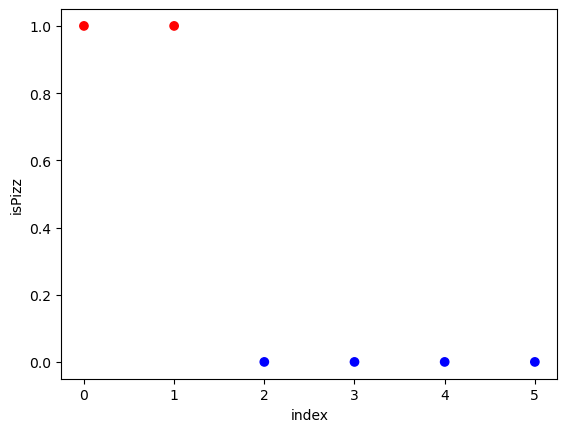

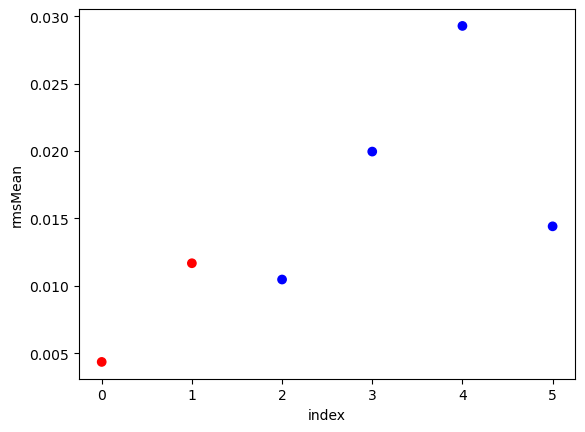

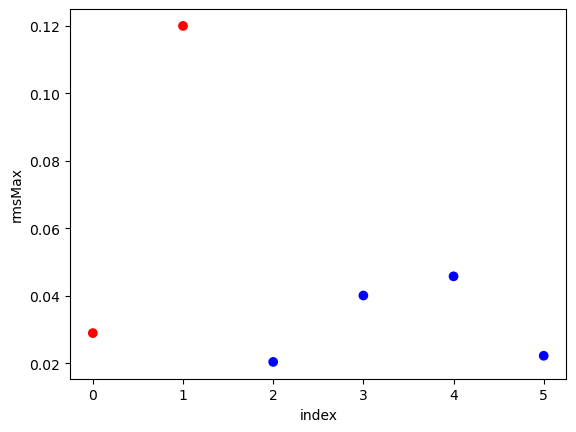

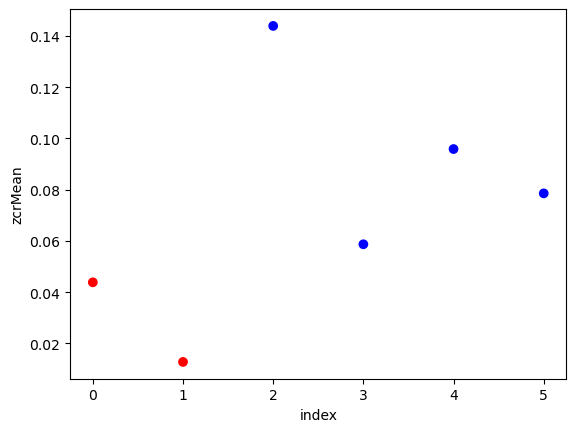

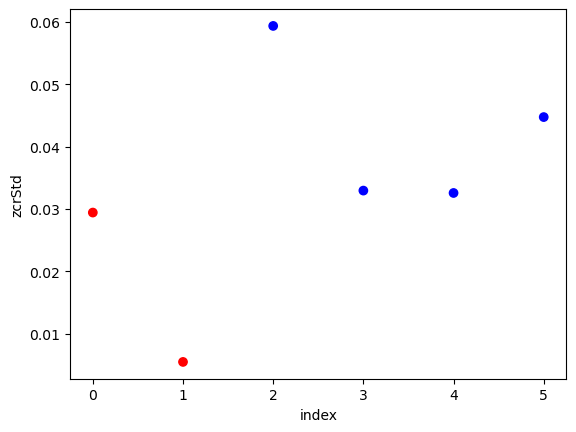

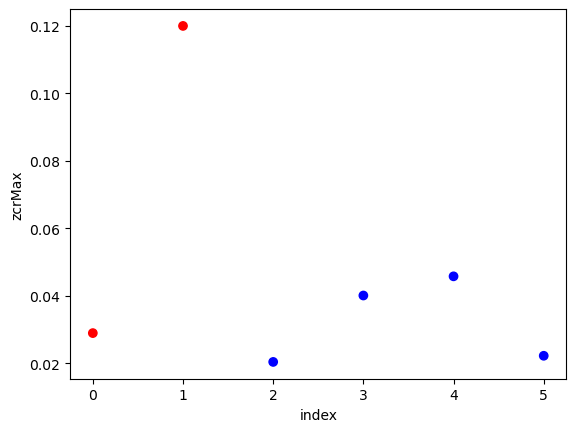

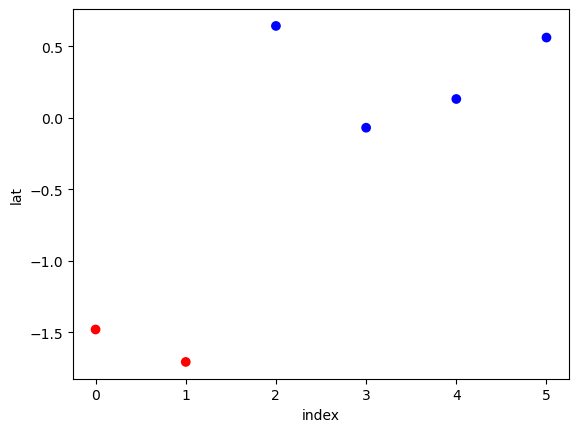

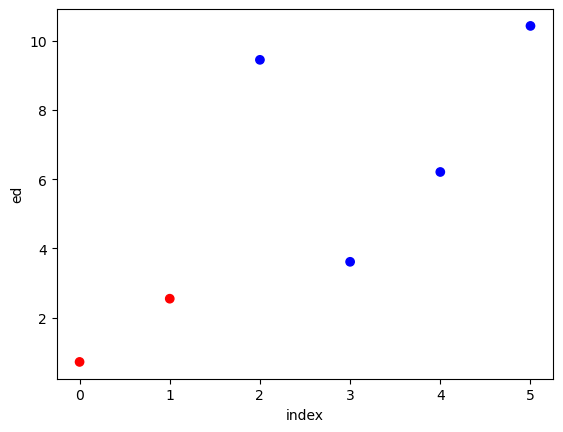

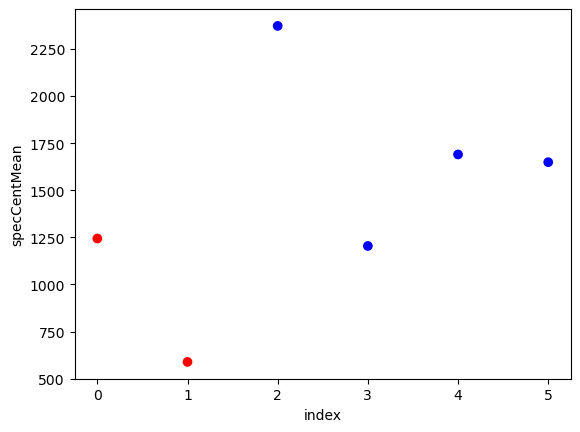

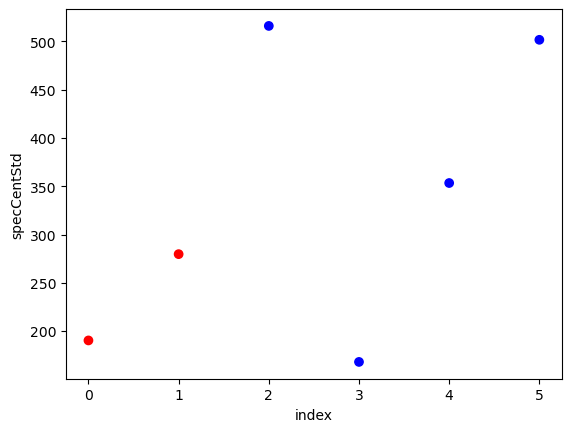

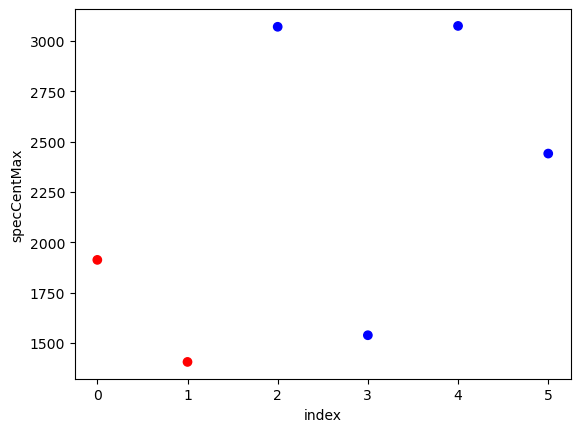

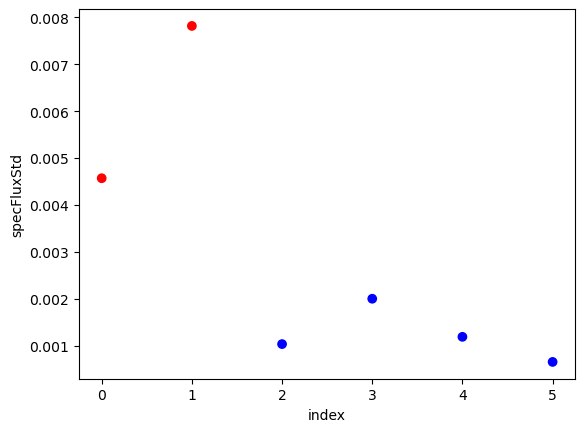

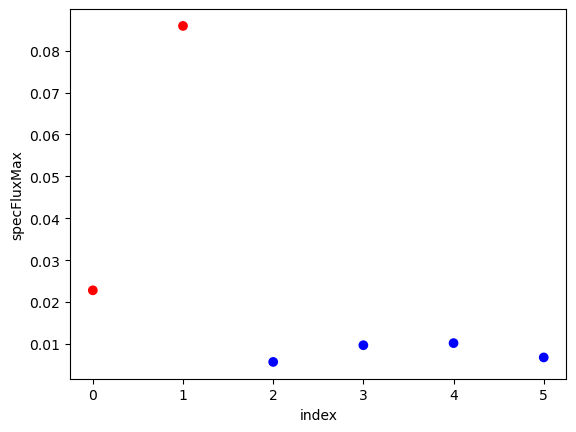

In [54]:
colors = ['red','red','blue','blue','blue','blue']
for col in columns:
    plt.scatter(descriptorsDf.index, descriptorsDf[col], c=colors,cmap="bwr_r")
    plt.xlabel("index")
    plt.ylabel(col)
    plt.show()

##### More plots

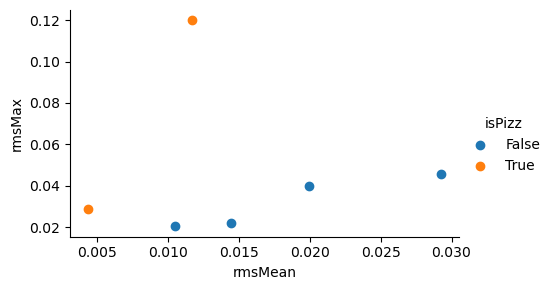

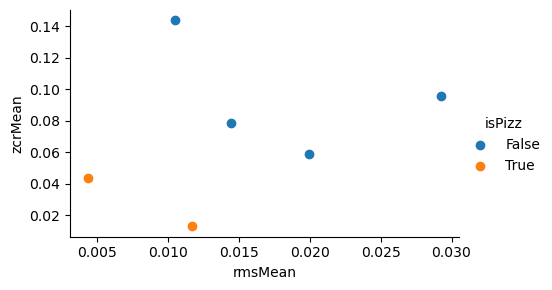

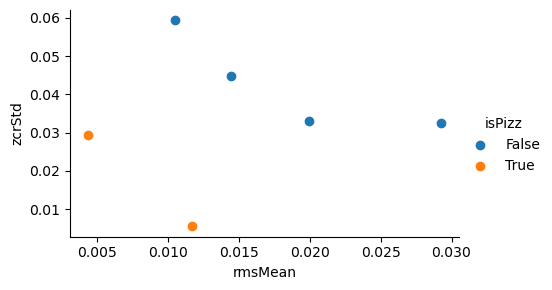

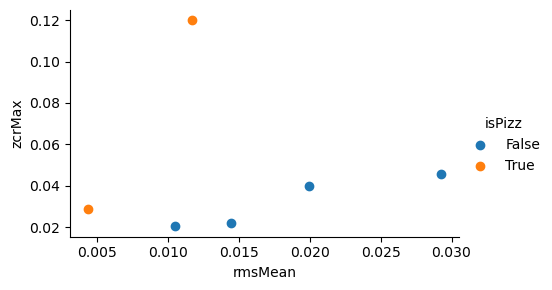

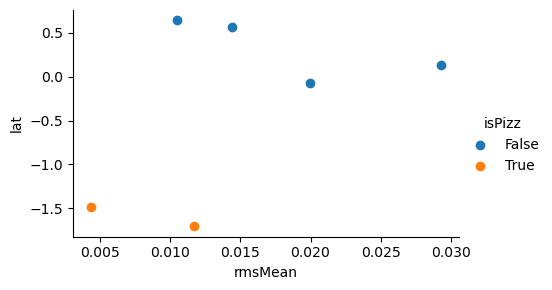

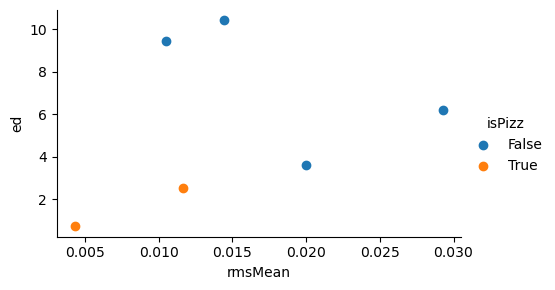

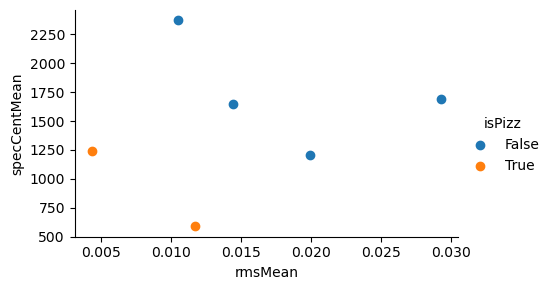

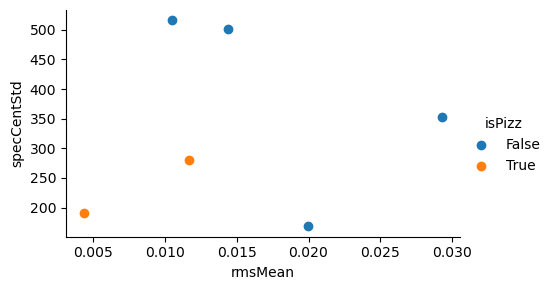

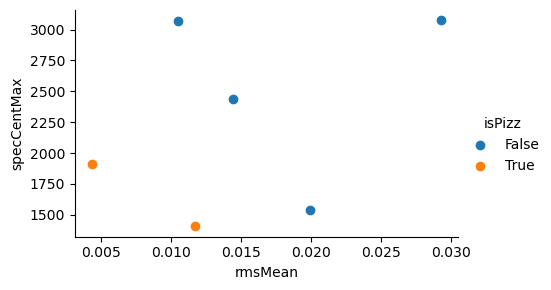

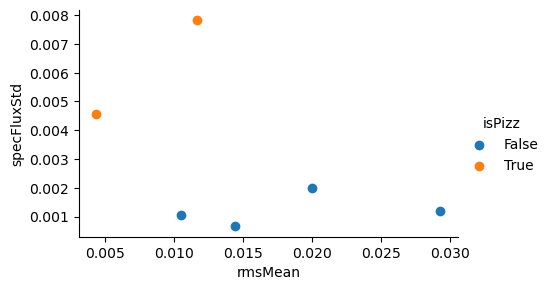

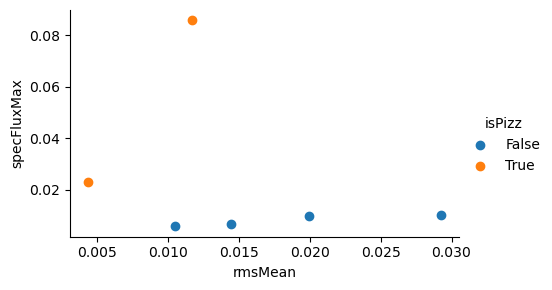

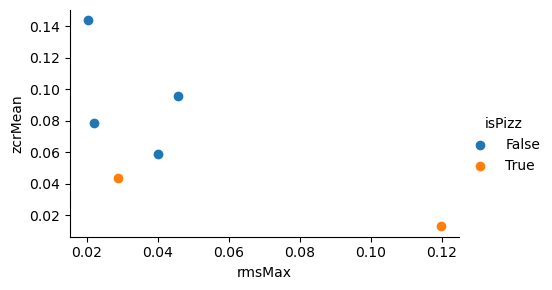

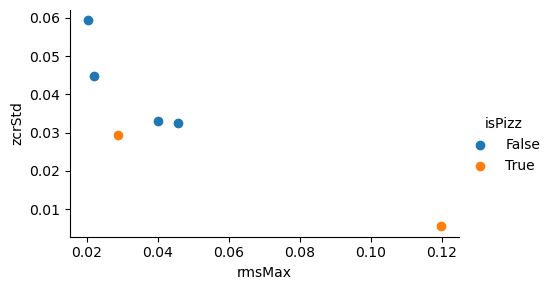

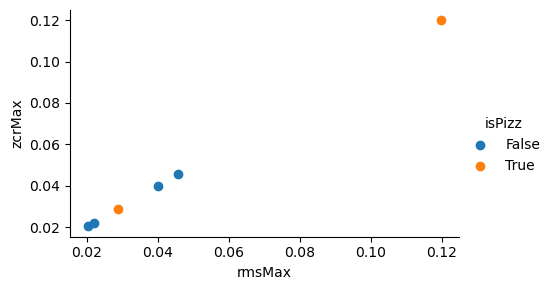

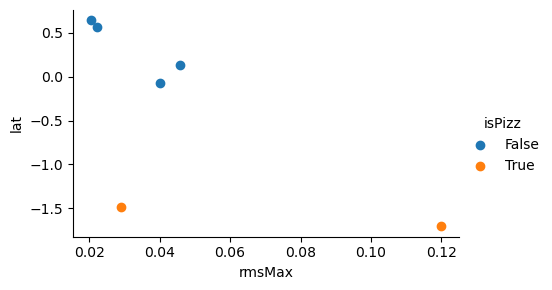

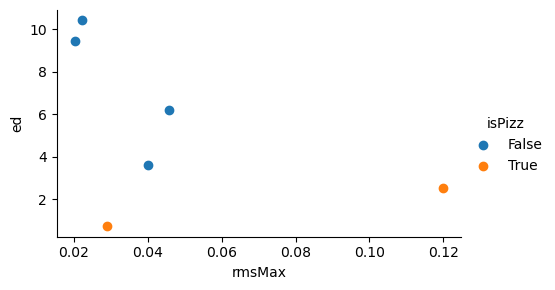

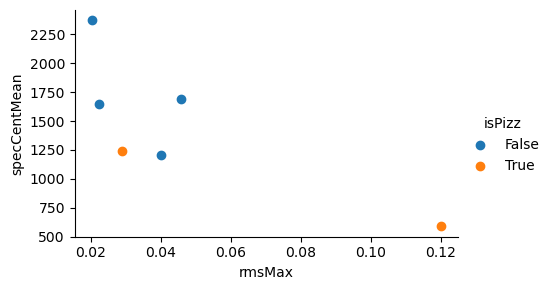

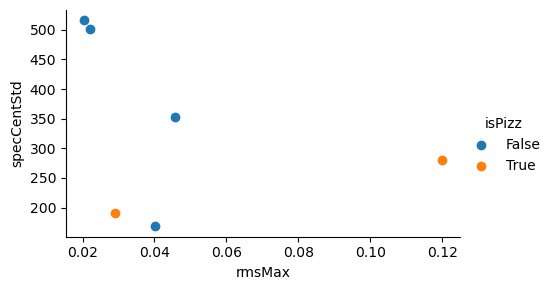

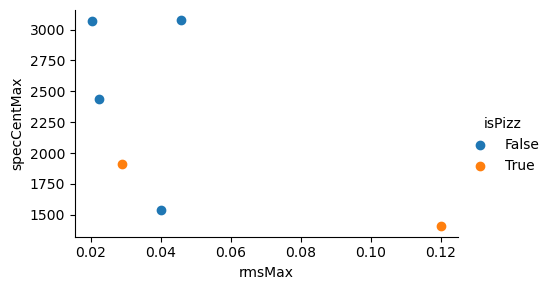

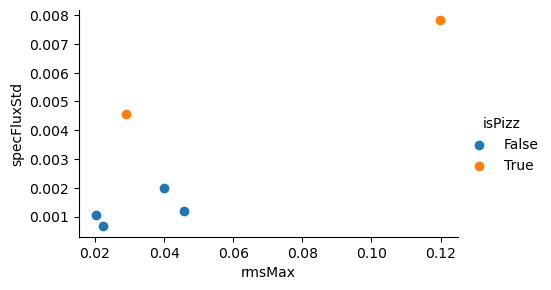

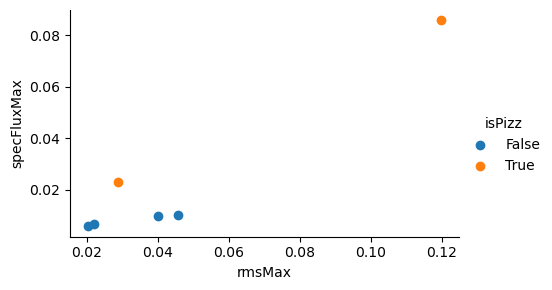

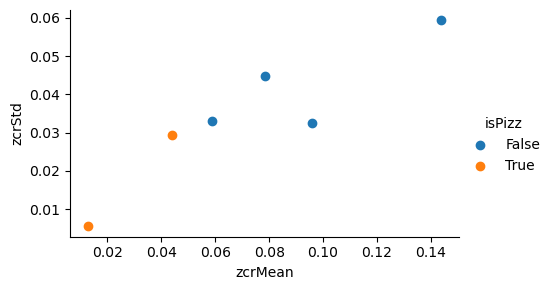

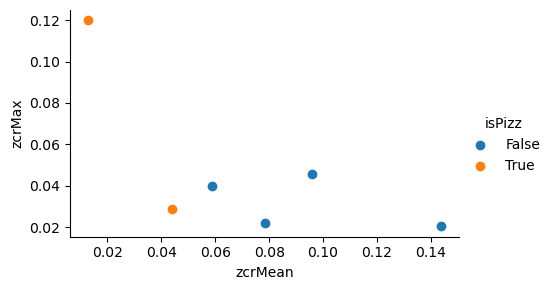

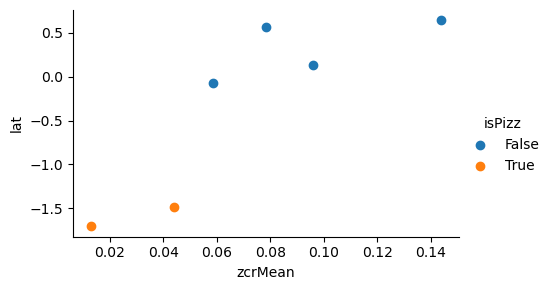

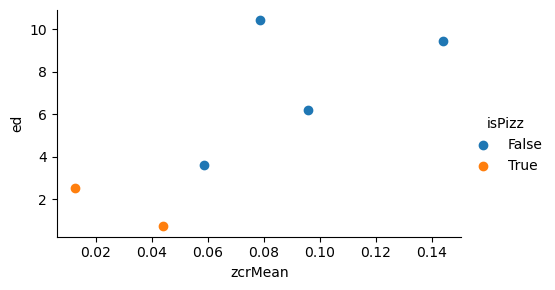

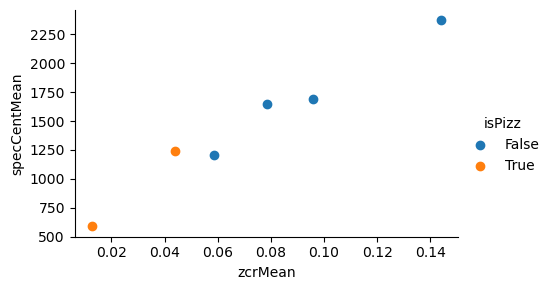

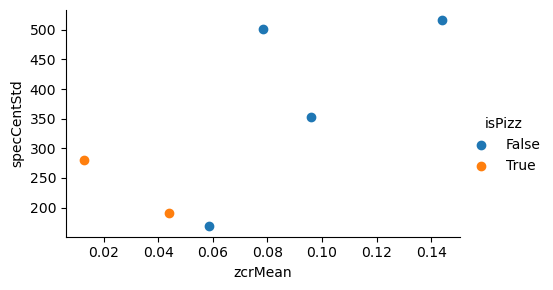

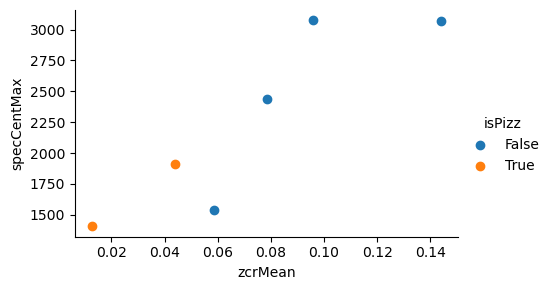

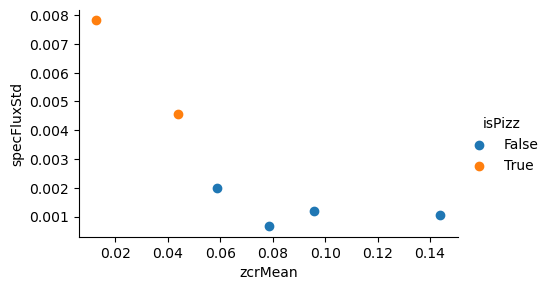

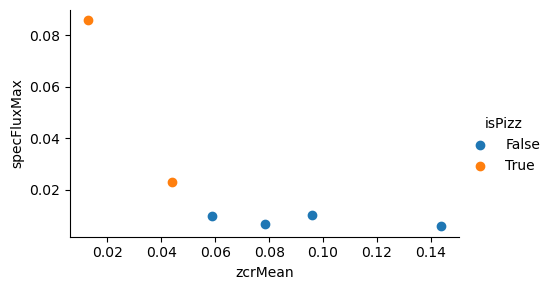

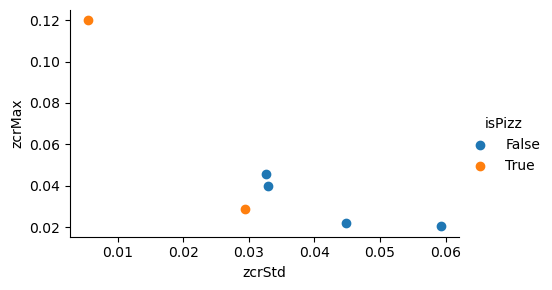

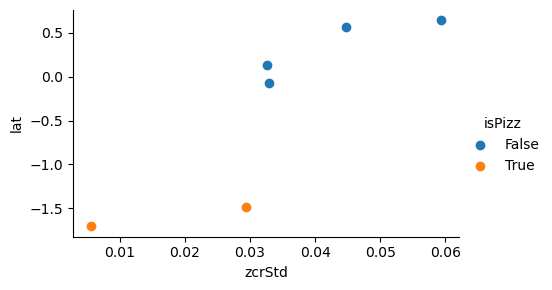

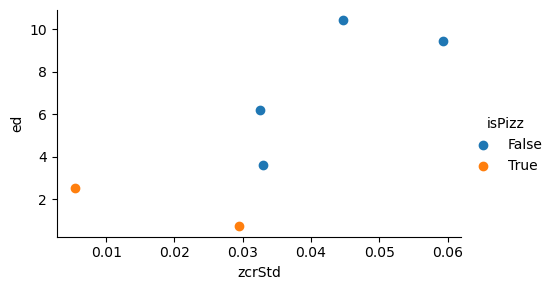

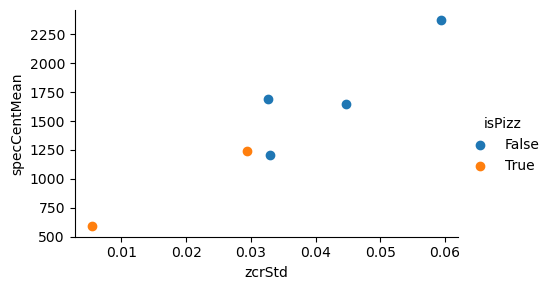

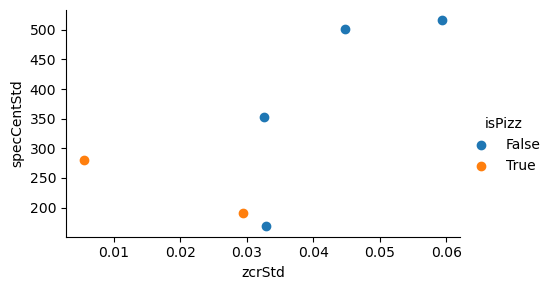

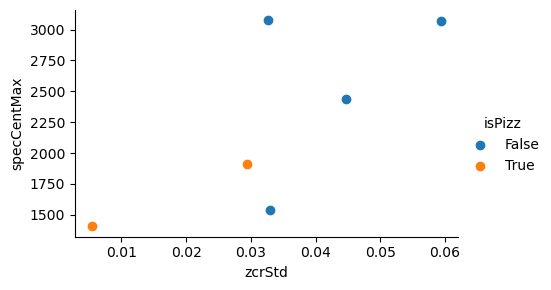

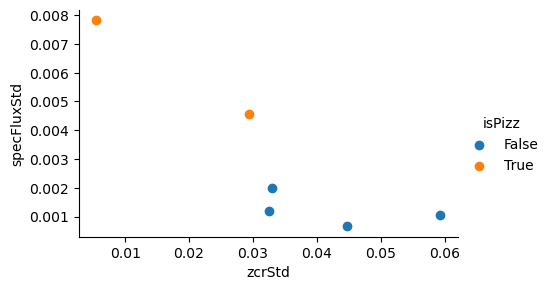

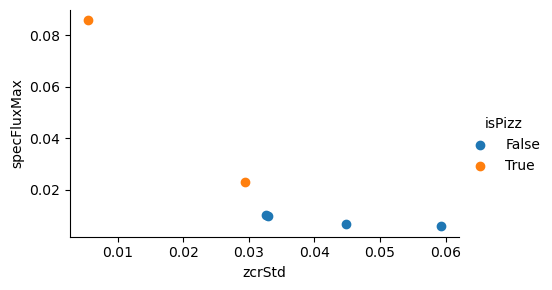

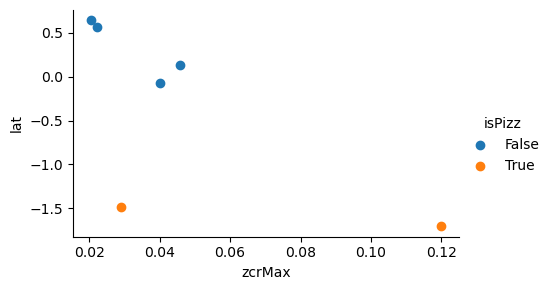

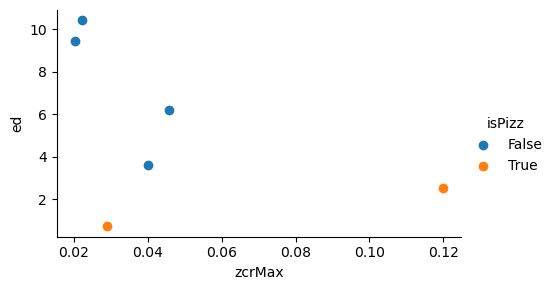

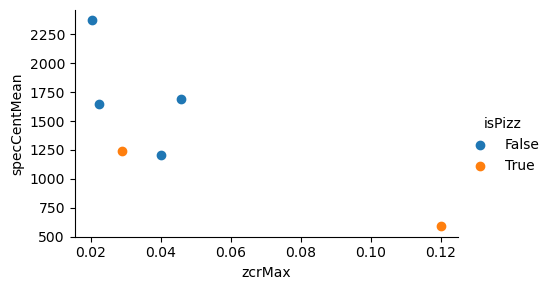

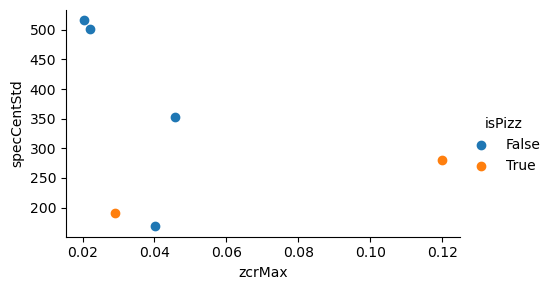

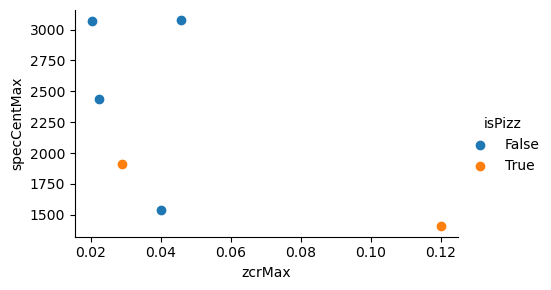

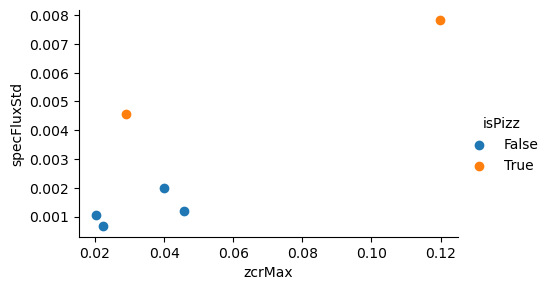

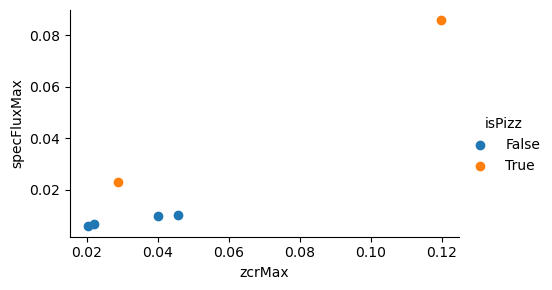

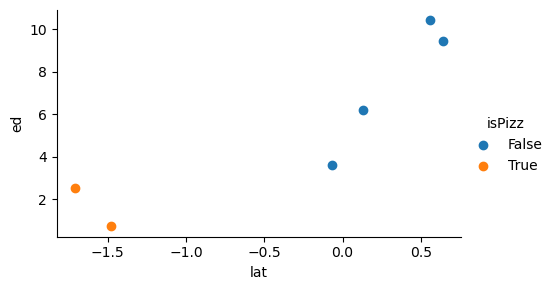

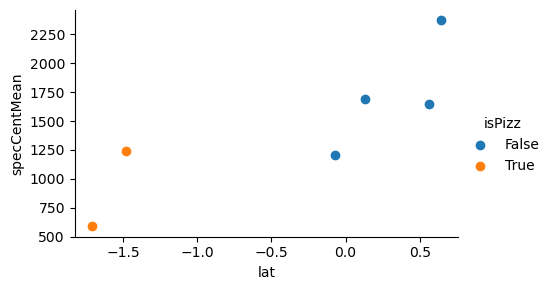

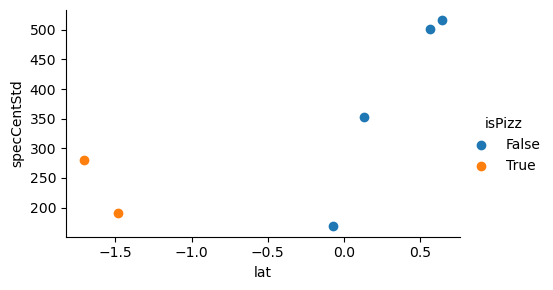

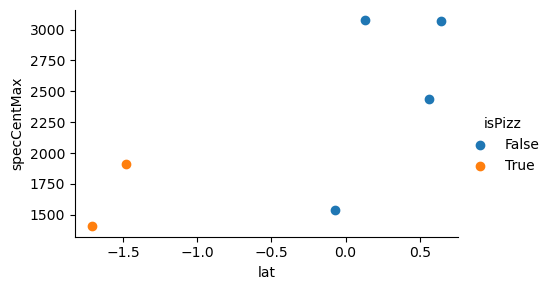

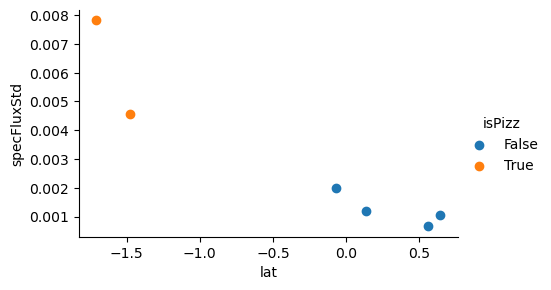

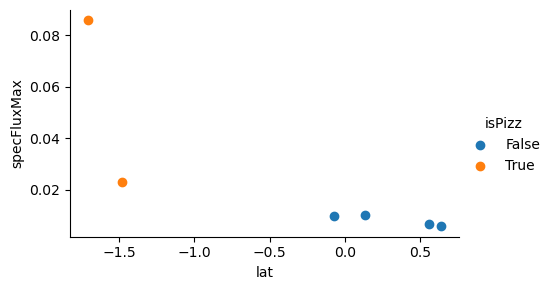

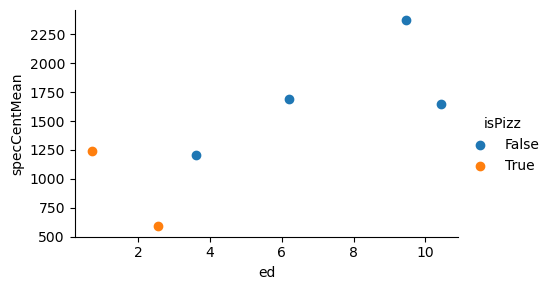

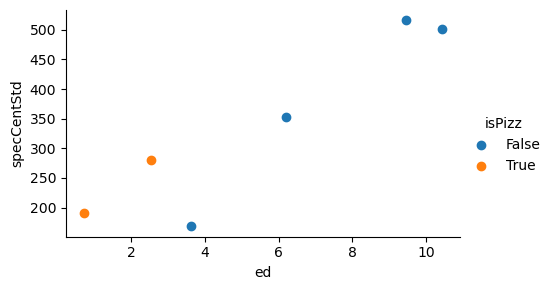

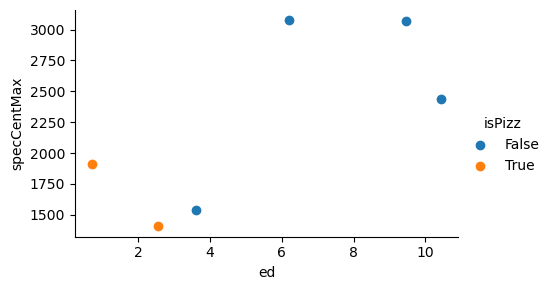

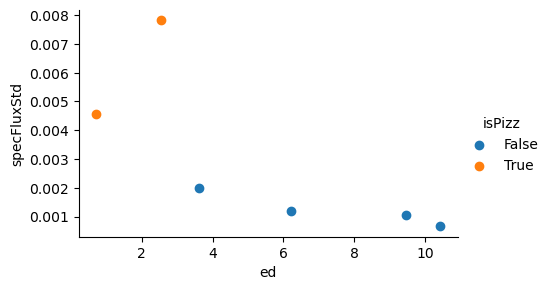

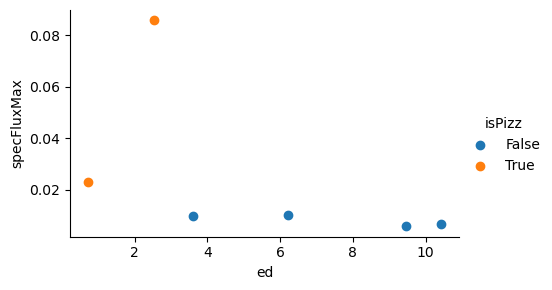

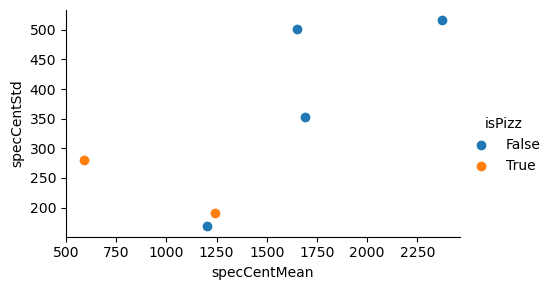

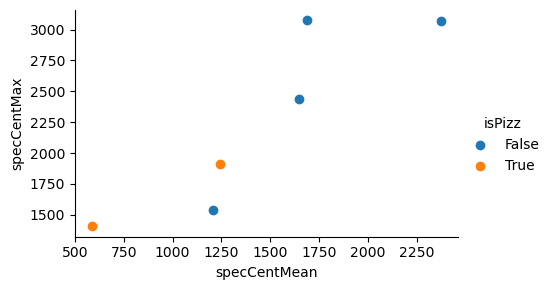

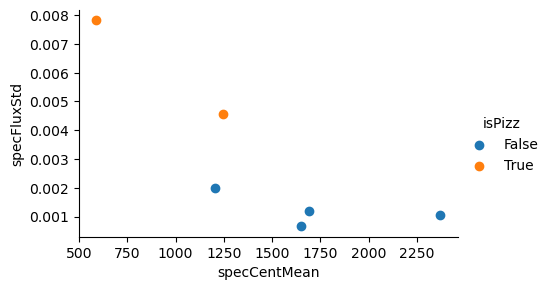

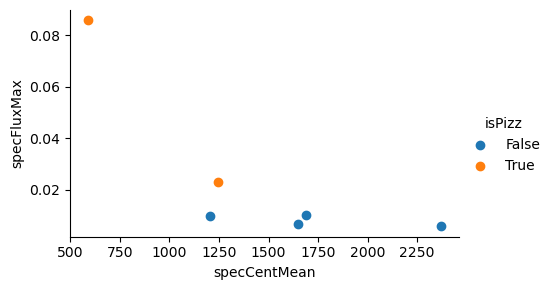

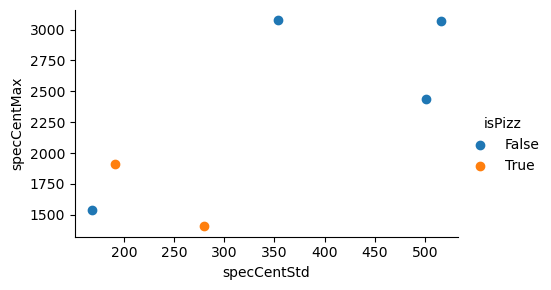

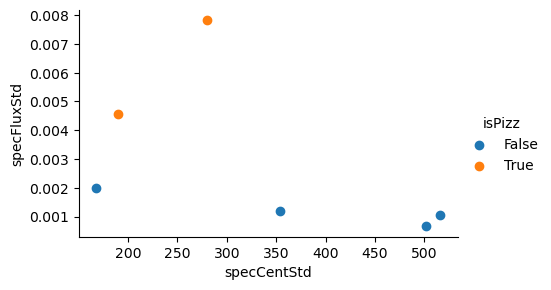

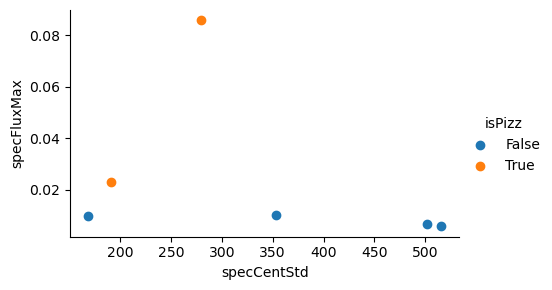

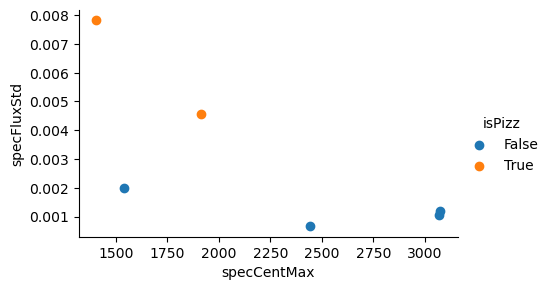

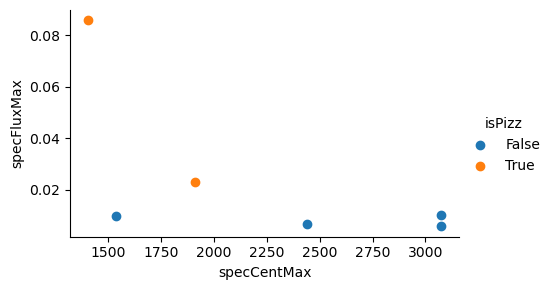

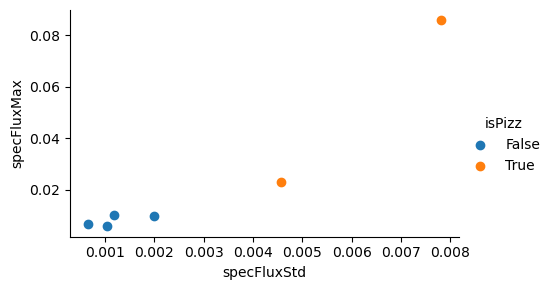

In [55]:
for col1 in range(1, len(columns)-1):
    for col2 in range(col1+1, len(columns)):
        fg = sns.FacetGrid(data=descriptorsDf, hue='isPizz', aspect=1.61)
        fg.map(matplotlib.pyplot.scatter, columns[col1], columns[col2]).add_legend()
        plt.show()

##### Most interesting
- zcrMean vs rmsMean
- zcrStd vs rmsMean
- lat vs anything
- specCentMean vs rmsMean
- specFluxStd vs rmsMean/rmsMax
- specFluxMax vs rmsMean
- specFluxStd vs zcrMax

zcrMean is lower in the pizz sounds, but that is most likely due to the pitch of the sound (right?).

lat is (a lot) lower in the pizz sounds

ed is lower in pizz sounds

specFluxStd is higher in pizz sounds

#### Study the pitch

In [56]:
descriptorsDf["note"] = descriptorsDf["name"].apply(lambda x: x.split("_")[2] if(x.split("_")[1].islower()) else x.split("_")[1])
display(descriptorsDf)

name type  isPizz   rmsMean    rmsStd    rmsMax    rmsMin  \
0  vln_e_C5_12_pizz.wav  vln    True  0.004351  0.007453  0.028905  0.000589   
1  cbs_g_C2_12_pizz.wav  cbs    True  0.011676  0.017423  0.119929  0.000825   
2       vln_a_G4_12.wav  vln   False  0.010467  0.005329  0.020362  0.000822   
3       cbs_g_G3_12.wav  cbs   False  0.019962  0.014279  0.040043  0.000796   
4         trp_G4_12.wav  trp   False  0.029288  0.016377  0.045727  0.000035   
5         sax_G4_12.wav  sax   False  0.014415  0.006439  0.022185  0.000784   

    zcrMean    zcrStd    zcrMax  ...    specBwMin  specFluxMean specFluxStd  \
0  0.043852  0.029426  0.028905  ...  1252.011087      0.002219    0.004572   
1  0.012781  0.005483  0.119929  ...   571.219462      0.002491    0.007817   
2  0.143910  0.059345  0.020362  ...  1624.886802      0.002030    0.001037   
3  0.058696  0.032948  0.040043  ...  1051.130000      0.002618    0.002003   
4  0.095863  0.032566  0.045727  ...   850.890971      0.001298    0.001191   
5  0.078564  0.044733  0.022185  ...  1116.769821      0.000908    0.000657   

   specFluxMax  specFluxMin  specFlatMean  specFlatStd  specFlatMax  \
0     0.022820          0.0      0.001262     0.001075     0.007143   
1     0.085896          0.0      0.000172     0.000259     0.001513   
2     0.005733          0.0      0.000854     0.000703     0.006840   
3     0.009720          0.0      0.000331     0.000382     0.001746   
4     0.010221          0.0      0.001190     0.003340     0.020041   
5     0.006804          0.0      0.000061     0.000050     0.000487   

   specFlatMin  note  
0     0.000075    C5  
1     0.000002    C2  
2     0.000249    G4  
3     0.000049    G3  
4     0.000005    G4  
5     0.000011    G4  

[6 rows x 31 columns]

##### Zcr

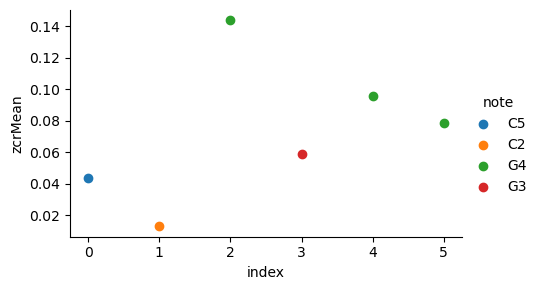

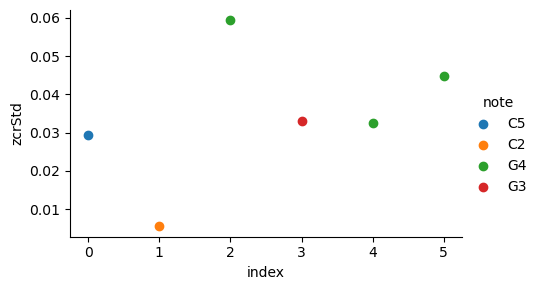

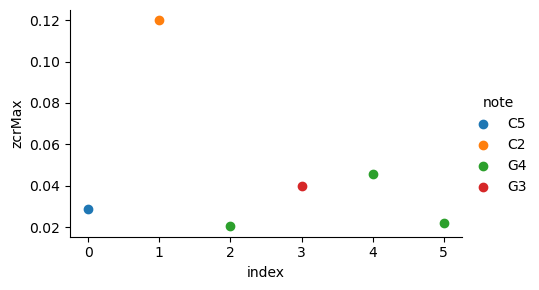

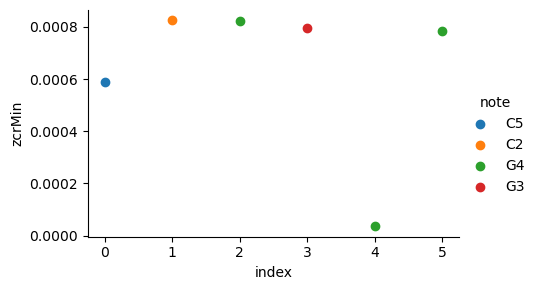

In [57]:
fg = sns.FacetGrid(data=descriptorsDf.reset_index(), hue='note', aspect=1.61)
fg.map(matplotlib.pyplot.scatter, 'index', 'zcrMean').add_legend()
plt.show()

fg = sns.FacetGrid(data=descriptorsDf.reset_index(), hue='note', aspect=1.61)
fg.map(matplotlib.pyplot.scatter, 'index', 'zcrStd').add_legend()
plt.show()

fg = sns.FacetGrid(data=descriptorsDf.reset_index(), hue='note', aspect=1.61)
fg.map(matplotlib.pyplot.scatter, 'index', 'zcrMax').add_legend()
plt.show()

fg = sns.FacetGrid(data=descriptorsDf.reset_index(), hue='note', aspect=1.61)
fg.map(matplotlib.pyplot.scatter, 'index', 'zcrMin').add_legend()
plt.show()

We had though that the zero crossing rate would indicate whether a sound had higher or lower pitch, but that doesn't seem to be the case

##### Encode the note col and apply the same method used for percursive/non percursive study

In [58]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
notes = []
for octave in range(1, 9):
    for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        notes.append(letter + str(octave))

le.fit(notes)

LabelEncoder()

In [60]:
descriptorsDf['note'] = le.fit_transform(descriptorsDf['note'])
display(descriptorsDf)

name type  isPizz   rmsMean    rmsStd    rmsMax    rmsMin  \
0  vln_e_C5_12_pizz.wav  vln    True  0.004351  0.007453  0.028905  0.000589   
1  cbs_g_C2_12_pizz.wav  cbs    True  0.011676  0.017423  0.119929  0.000825   
2       vln_a_G4_12.wav  vln   False  0.010467  0.005329  0.020362  0.000822   
3       cbs_g_G3_12.wav  cbs   False  0.019962  0.014279  0.040043  0.000796   
4         trp_G4_12.wav  trp   False  0.029288  0.016377  0.045727  0.000035   
5         sax_G4_12.wav  sax   False  0.014415  0.006439  0.022185  0.000784   

    zcrMean    zcrStd    zcrMax  ...    specBwMin  specFluxMean specFluxStd  \
0  0.043852  0.029426  0.028905  ...  1252.011087      0.002219    0.004572   
1  0.012781  0.005483  0.119929  ...   571.219462      0.002491    0.007817   
2  0.143910  0.059345  0.020362  ...  1624.886802      0.002030    0.001037   
3  0.058696  0.032948  0.040043  ...  1051.130000      0.002618    0.002003   
4  0.095863  0.032566  0.045727  ...   850.890971      0.001298    0.001191   
5  0.078564  0.044733  0.022185  ...  1116.769821      0.000908    0.000657   

   specFluxMax  specFluxMin  specFlatMean  specFlatStd  specFlatMax  \
0     0.022820          0.0      0.001262     0.001075     0.007143   
1     0.085896          0.0      0.000172     0.000259     0.001513   
2     0.005733          0.0      0.000854     0.000703     0.006840   
3     0.009720          0.0      0.000331     0.000382     0.001746   
4     0.010221          0.0      0.001190     0.003340     0.020041   
5     0.006804          0.0      0.000061     0.000050     0.000487   

   specFlatMin  note  
0     0.000075     1  
1     0.000002     0  
2     0.000249     3  
3     0.000049     2  
4     0.000005     3  
5     0.000011     3  

[6 rows x 31 columns]

In [61]:
threshold = 0.75
corr_matrix = descriptorsDf.corr()
corr_matrix = corr_matrix.loc[['note']]
corr_matrix = corr_matrix.loc[:, (abs(corr_matrix) > threshold).any()]
display(corr_matrix.head())
columns = corr_matrix.columns

C:\Users\mpspm\AppData\Local\Temp\ipykernel_13548\2647246693.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = descriptorsDf.corr()


isPizz    rmsMax   zcrMean    zcrStd    zcrMax       lat        ed  \
note -0.918559 -0.761749  0.868882  0.852132 -0.761749  0.962194  0.824767   

      specCentMean  specCentMax  specFluxStd  specFluxMax  note  
note      0.868873     0.827525    -0.978135    -0.872065   1.0

In [62]:
descriptorsDf['note'] = le.inverse_transform(descriptorsDf['note'])

##### Plots comparing the columns selected

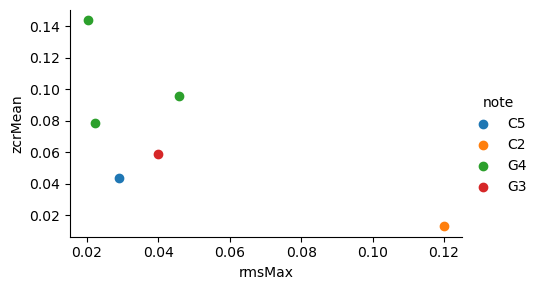

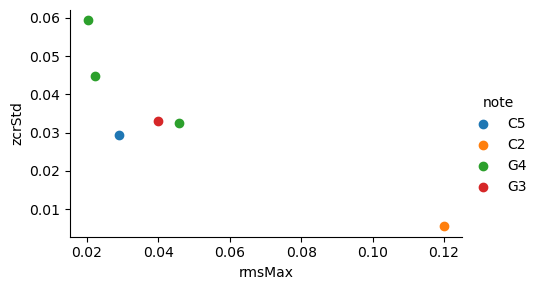

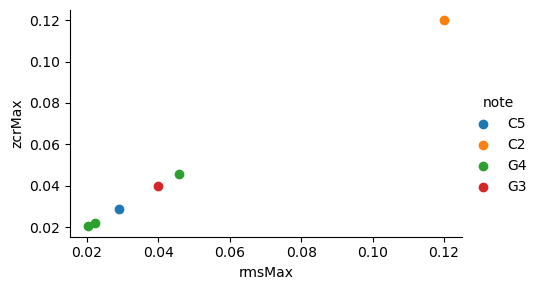

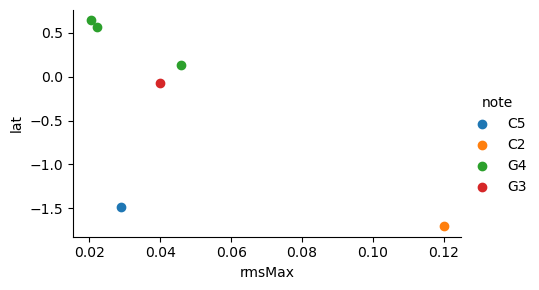

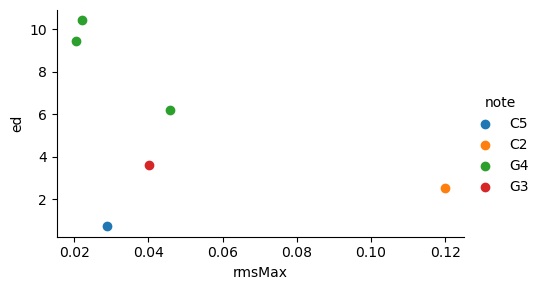

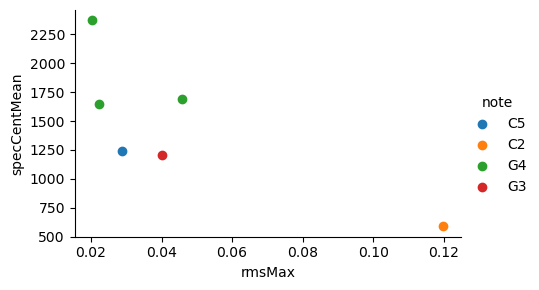

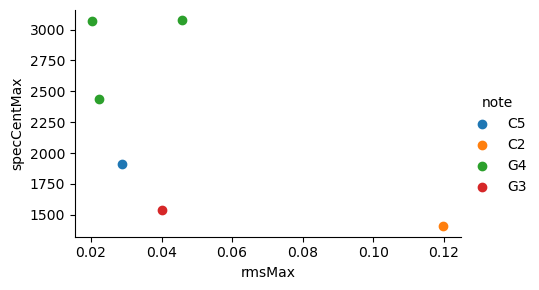

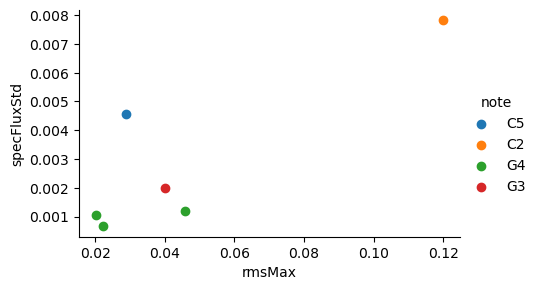

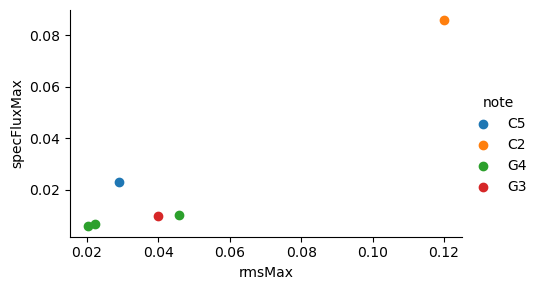

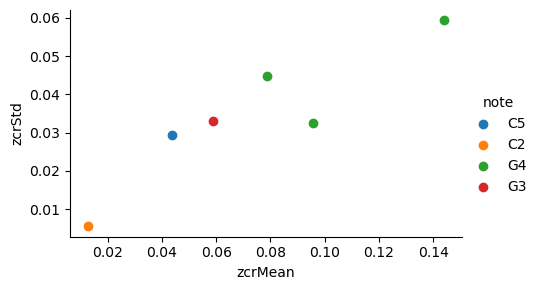

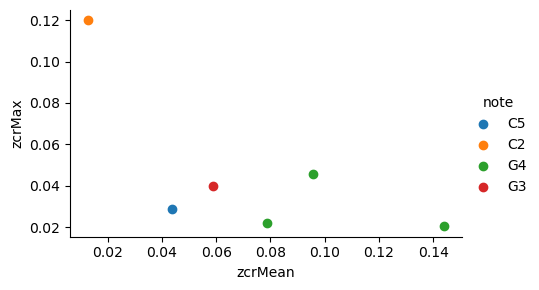

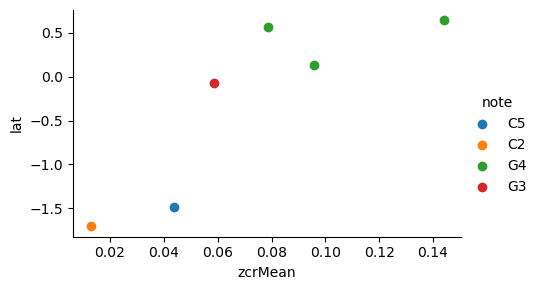

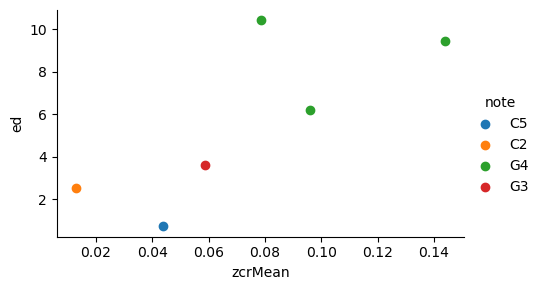

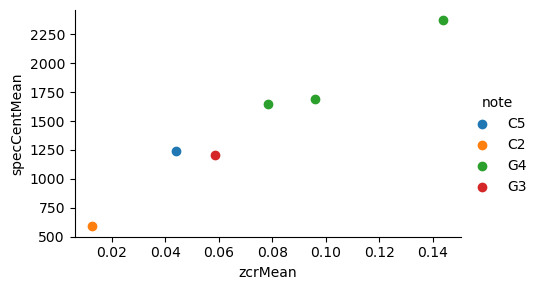

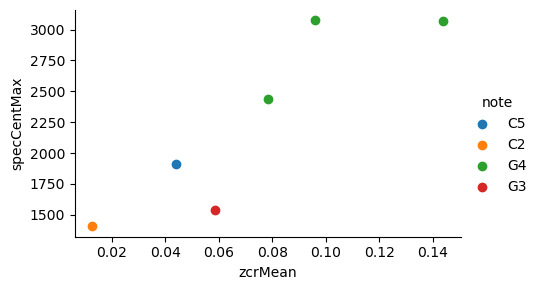

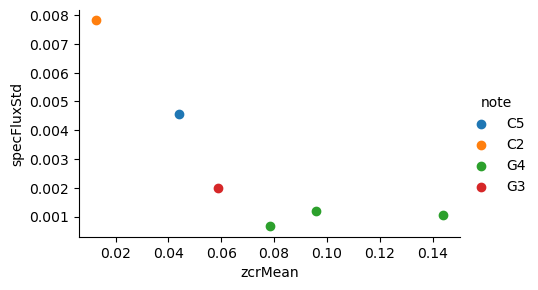

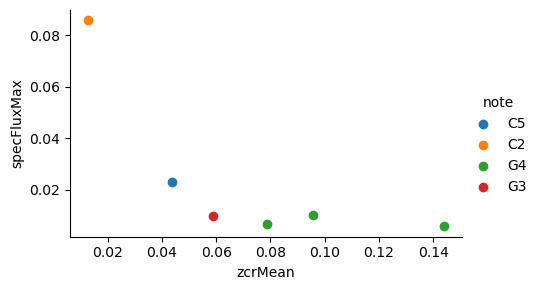

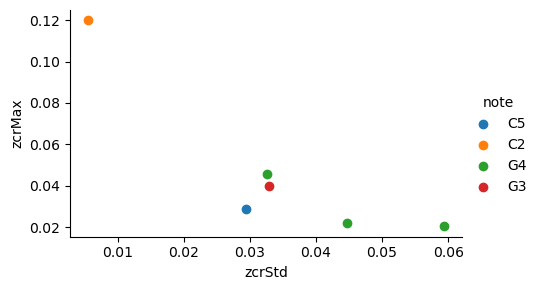

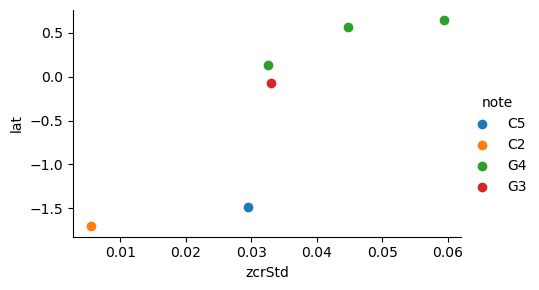

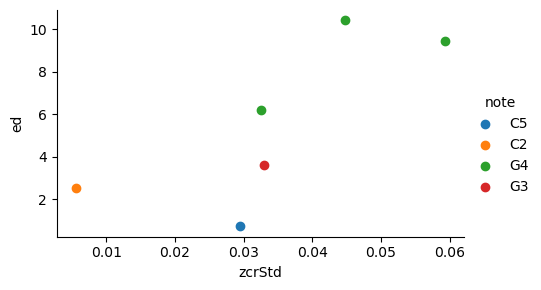

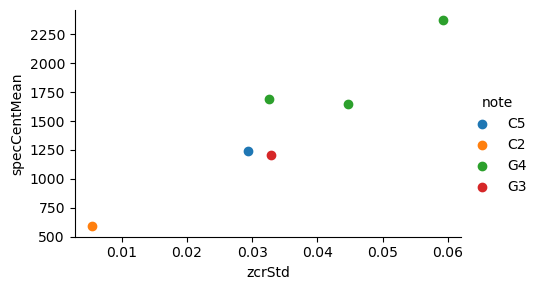

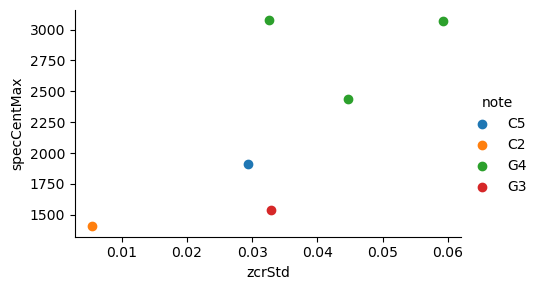

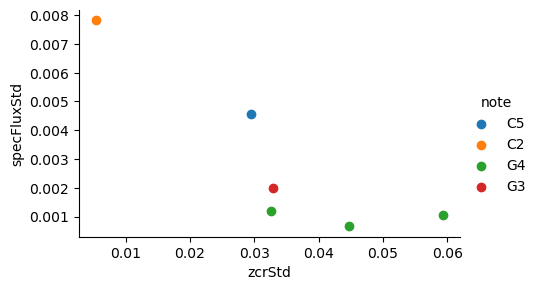

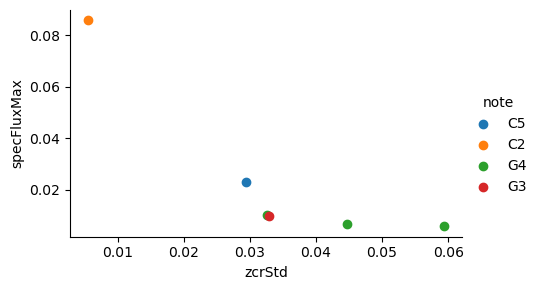

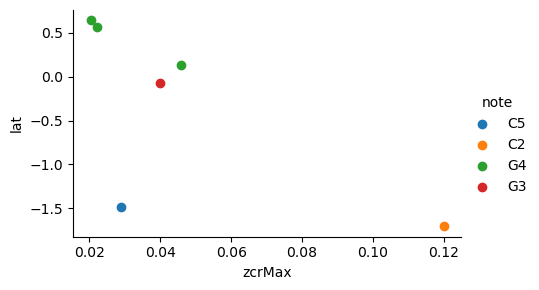

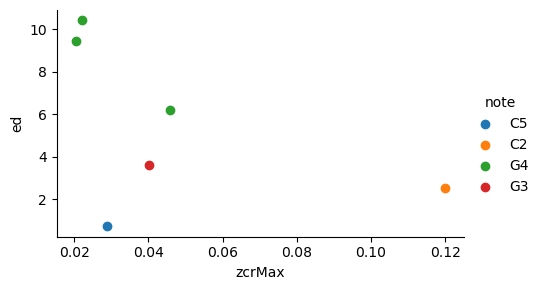

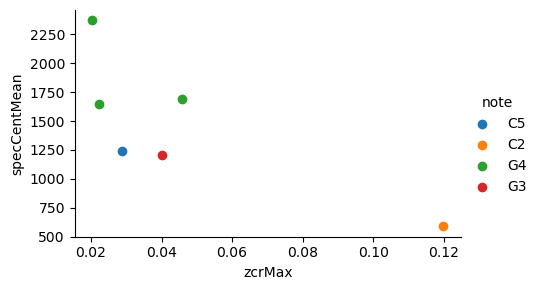

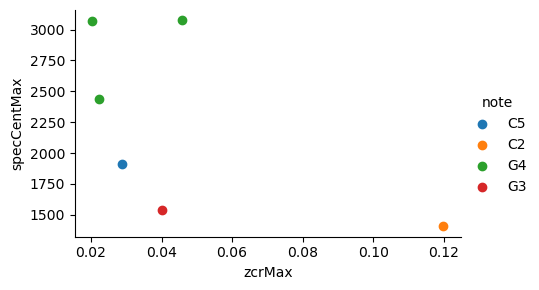

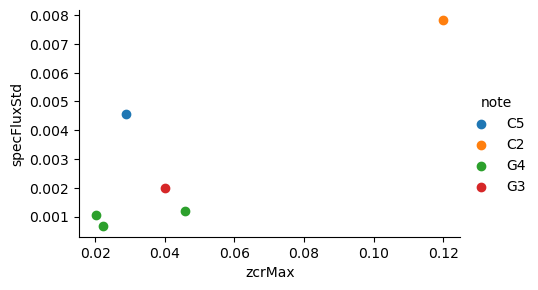

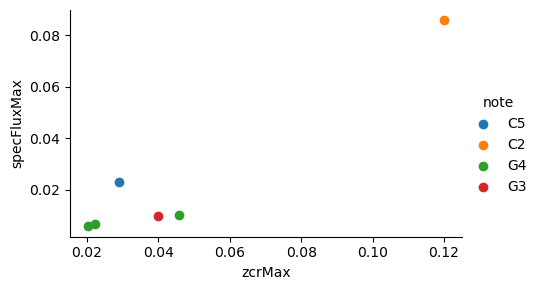

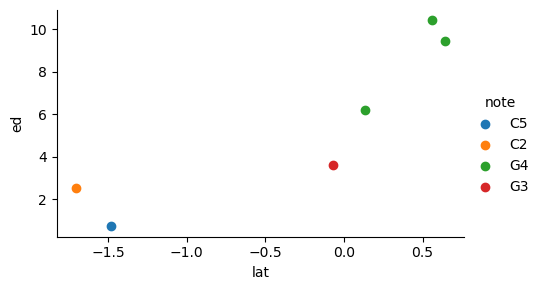

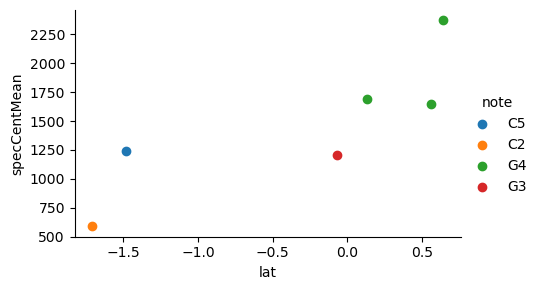

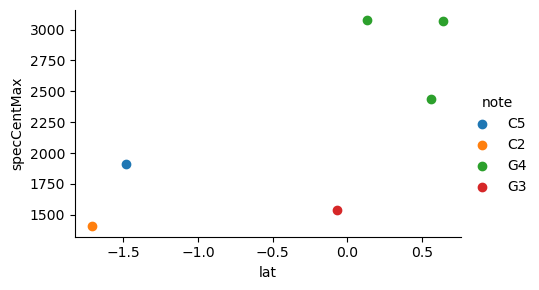

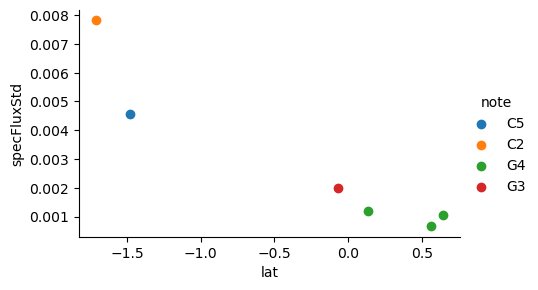

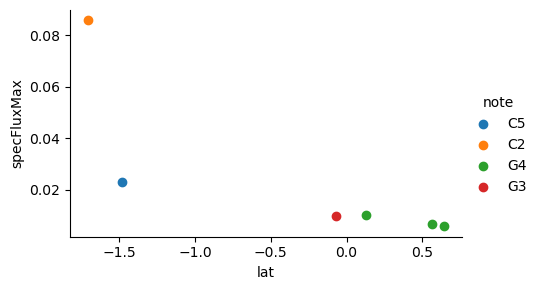

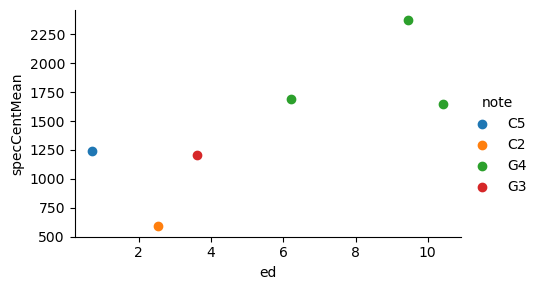

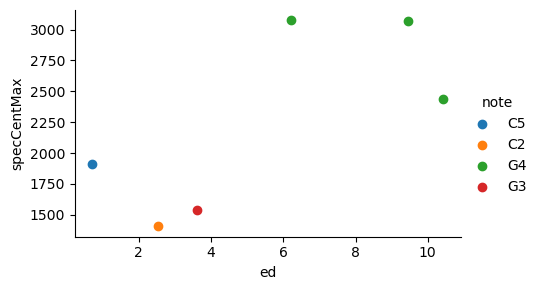

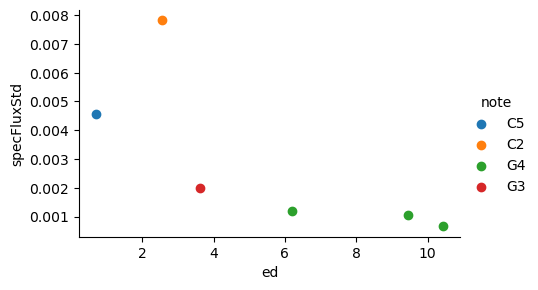

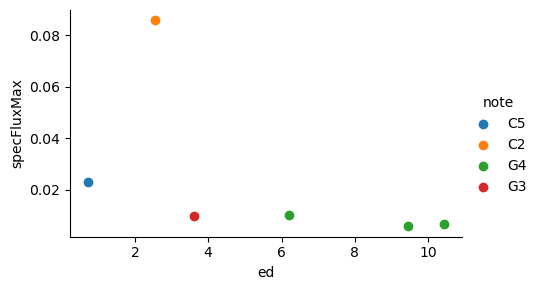

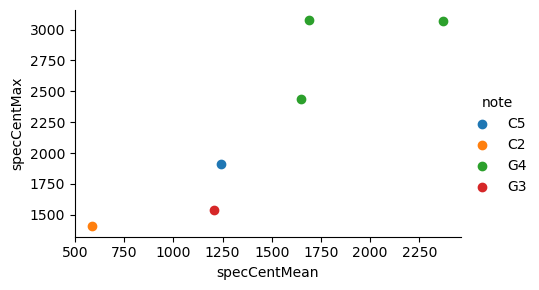

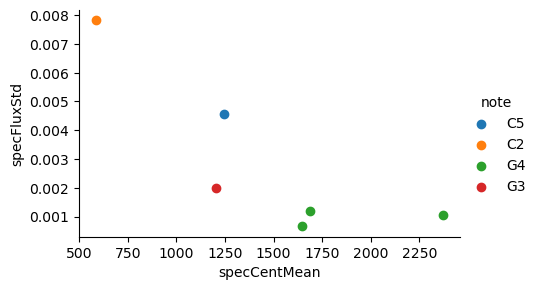

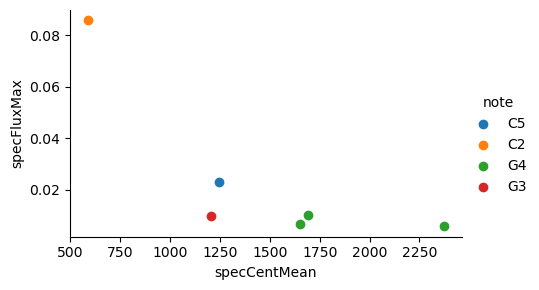

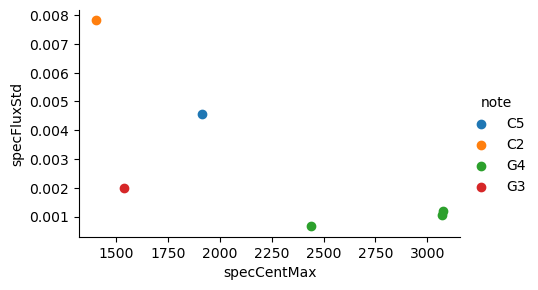

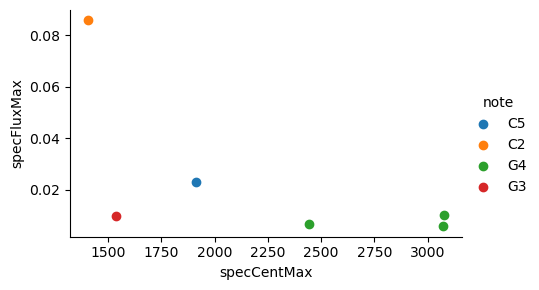

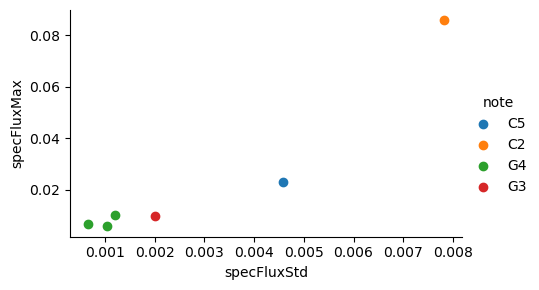

In [63]:
for col1 in range(1, len(columns)-2):
    for col2 in range(col1+1, len(columns)-1):
        fg = sns.FacetGrid(data=descriptorsDf, hue='note', aspect=1.61)
        fg.map(matplotlib.pyplot.scatter, columns[col1], columns[col2]).add_legend()
        plt.show()

## Task 3

### Applications

Describe in a short paragraph (max 4/5 lines) a sound-based multimedia application that could make use of this set of sound descriptors. 

## Task 3 answer

We can use this descriptors in a multitude of different applications, but we would argue that the general public won't give a lot of importance to then, usually people want the simplest and least complicated option. With that in mind, we can see two different applications, the first would be a simple application for the general population where they could upload a sound and the app would give it a score according to what the supposed values are, on the other hand, a second application could be for the music savants, in which they could detect the quality and purity of the sound.  


## Task 4

### Classification - Percussive / Non_percussive

In [812]:
import os
 
# Get the list of all files and directories
path = "./data/sounds"
allFiles = os.listdir(path)

soundDescriptors = {}

for fileName in allFiles:
    soundDescriptors[fileName] = []
    
    fileNameWav = os.path.join('.', 'data','sounds', fileName)
    fileVal, fileRate = librosa.load(fileNameWav)
    
    if "pizz" in fileName:
        soundDescriptors[fileName].append(True)
    else:
        soundDescriptors[fileName].append(False)
        
    rms = librosa.feature.rms(y=fileVal)
    rms_average = np.average(rms)
    rms_std = np.std(rms)
    soundDescriptors[fileName].append(rms_average)
    soundDescriptors[fileName].append(rms_std)
    
    zcr = librosa.feature.zero_crossing_rate(fileVal)
    zcr_average = np.average(zcr)
    zcr_std = np.std(zcr)
    soundDescriptors[fileName].append(zcr_average)
    soundDescriptors[fileName].append(zcr_std)
        
    lat = log_attack_time(fileVal, fileRate, start=0.01, end=0.99)
    soundDescriptors[fileName].append(lat)
    
    tc = temporal_centroid(fileVal, fileRate)
    soundDescriptors[fileName].append(tc)

    ed= effective_duration(fileVal, fileRate, threshold=0.05)
    soundDescriptors[fileName].append(ed)

    spec_cent = librosa.feature.spectral_centroid(y=fileVal, sr=fileRate)
    spec_cent_average = np.average(spec_cent)
    spec_cent_std = np.std(spec_cent)
    soundDescriptors[fileName].append(spec_cent_average)
    soundDescriptors[fileName].append(spec_cent_std)

    spec_bw = librosa.feature.spectral_bandwidth(y=fileVal, sr=fileRate)
    spec_bw_average = np.average(spec_bw)
    spec_bw_std = np.std(spec_bw)
    soundDescriptors[fileName].append(spec_bw_average)
    soundDescriptors[fileName].append(spec_bw_std)

    spec_flux = spectral_flux(fileVal)
    spec_flux_average = np.average(spec_flux)
    spec_flux_std = np.std(spec_flux)
    soundDescriptors[fileName].append(spec_flux_average)
    soundDescriptors[fileName].append(spec_flux_std)

    spec_flat = librosa.feature.spectral_flatness(y=fileVal)
    spec_flat_average = np.average(spec_flat)
    spec_flat_std = np.std(spec_flat)
    soundDescriptors[fileName].append(spec_flat_average)
    soundDescriptors[fileName].append(spec_flat_std)


In [813]:
import pandas as pd

soundDescriptorsDf = pd.DataFrame.from_dict(soundDescriptors)
soundDescriptorsDf = soundDescriptorsDf.iloc[1:]
s = soundDescriptorsDf.columns
soundDescriptorsDf = soundDescriptorsDf[s].astype(float)


['cbs_g_C2_12_pizz.wav', 'cbs_g_C2_12_pizz2.wav', 'vcl_a_C3_12_pizz.wav', 'vcl_a_C3_12_pizz2.wav', 'vln_e_C5_12_pizz.wav']
0


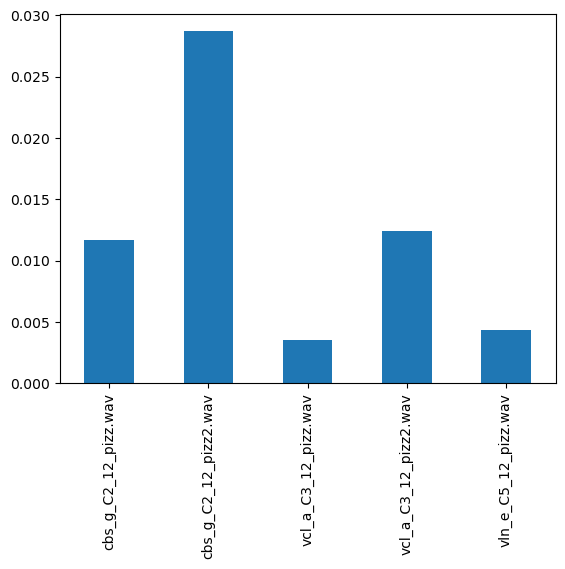

1


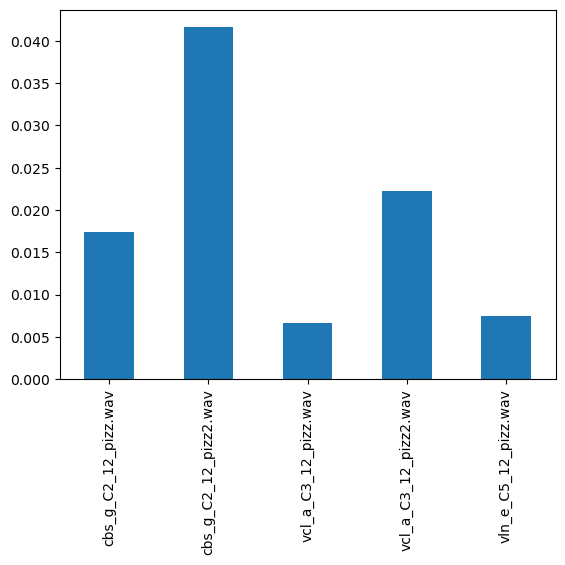

2


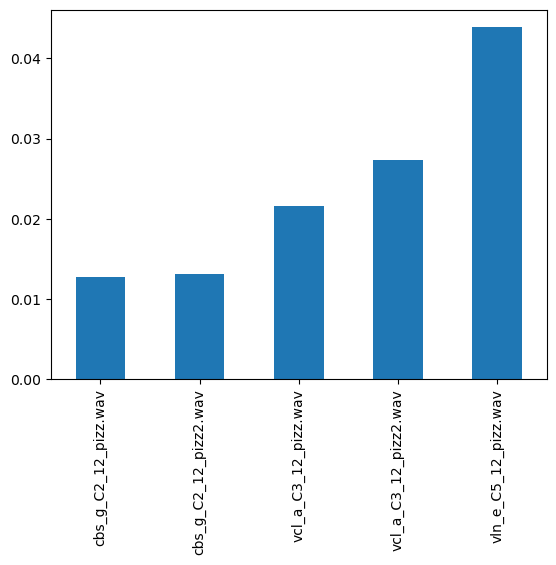

3


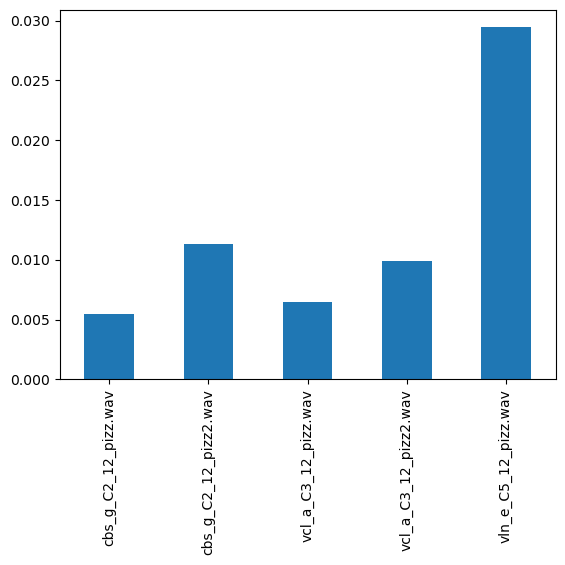

4


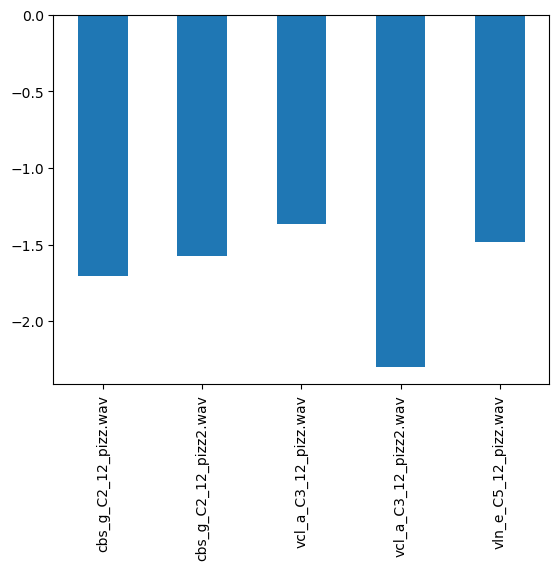

5


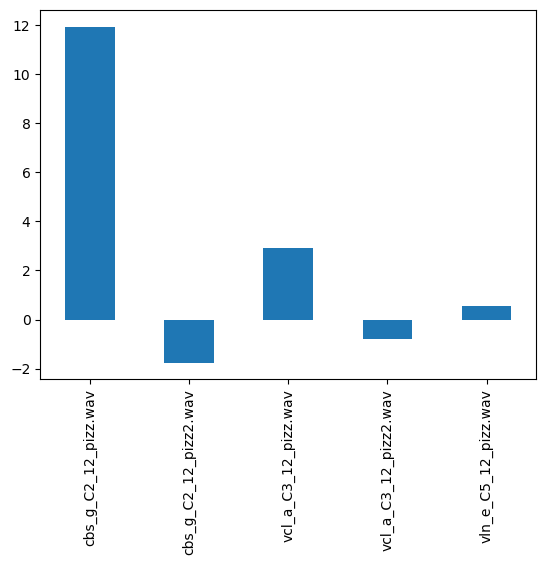

6


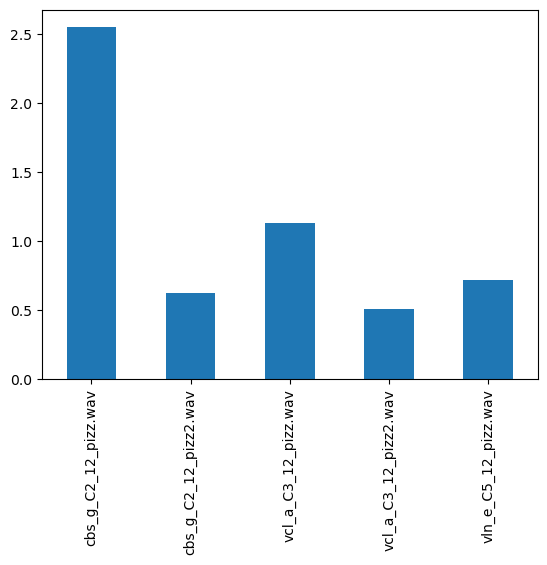

7


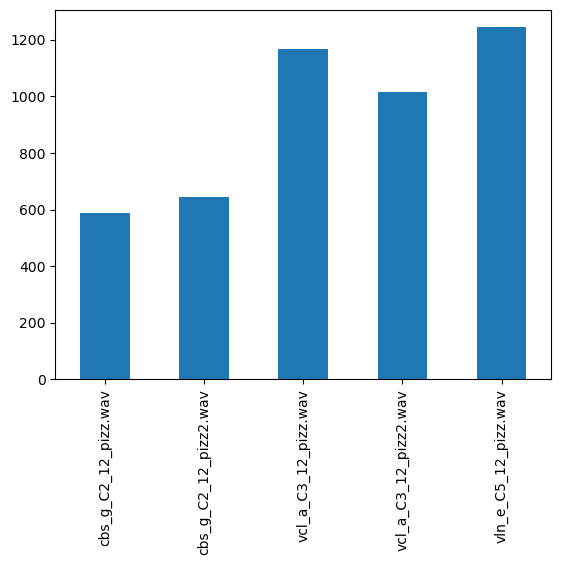

8


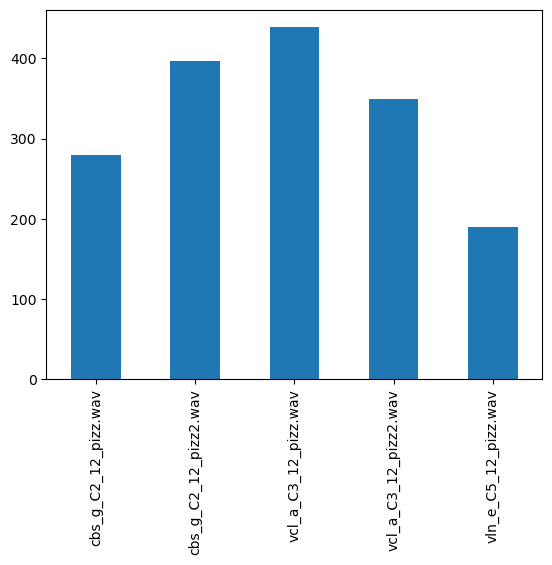

9


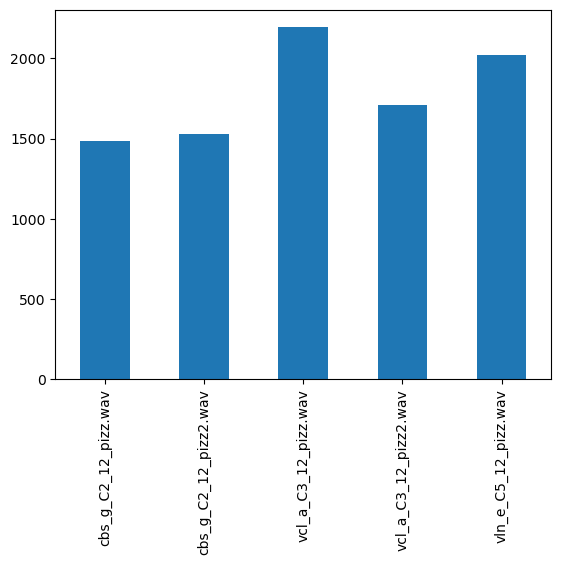

10


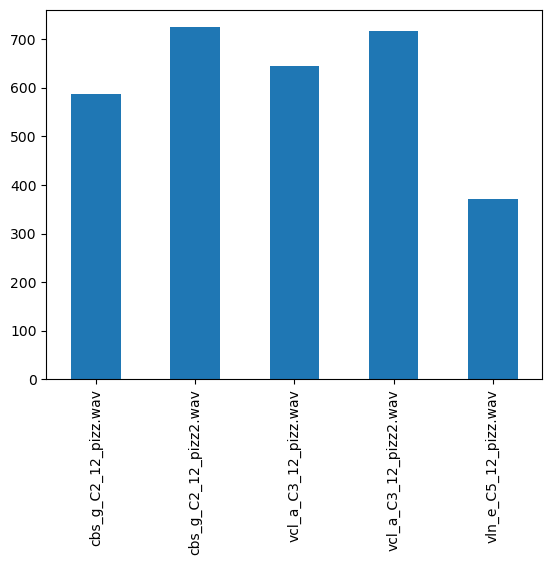

11


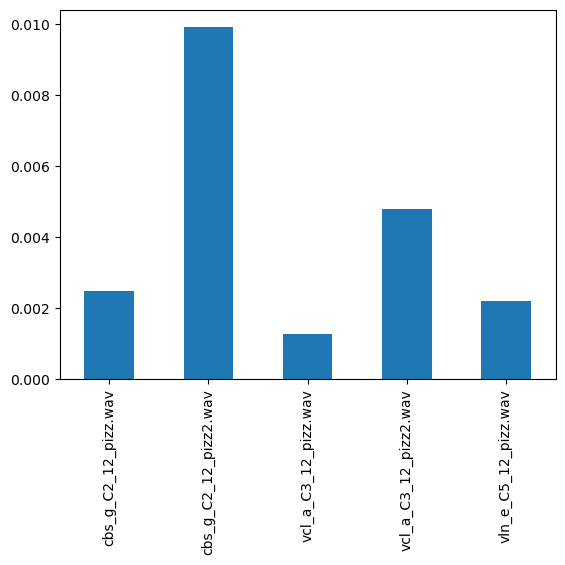

12


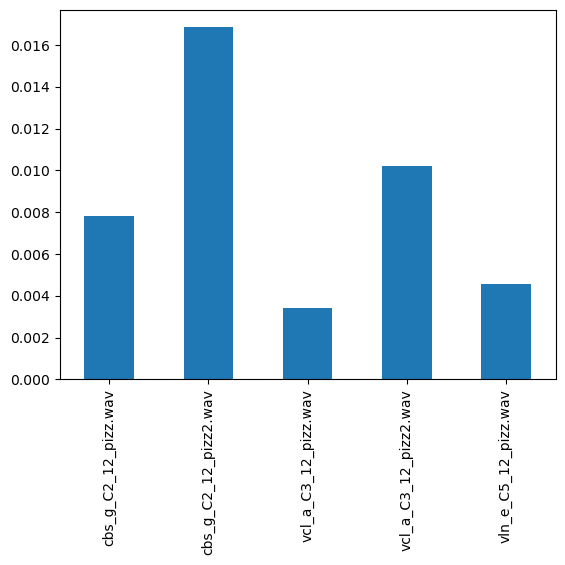

13


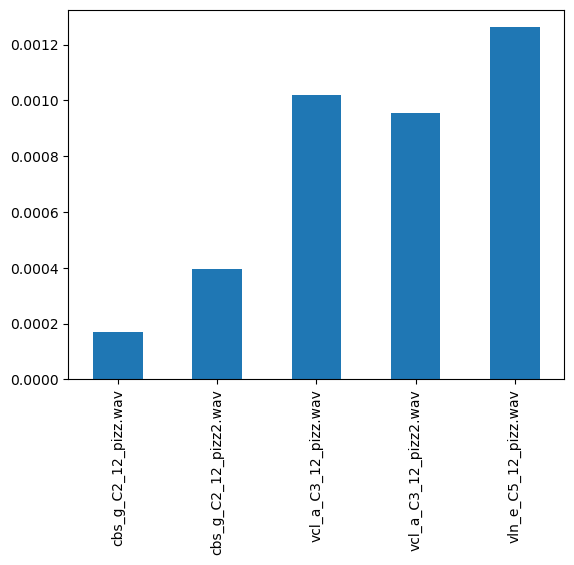

14


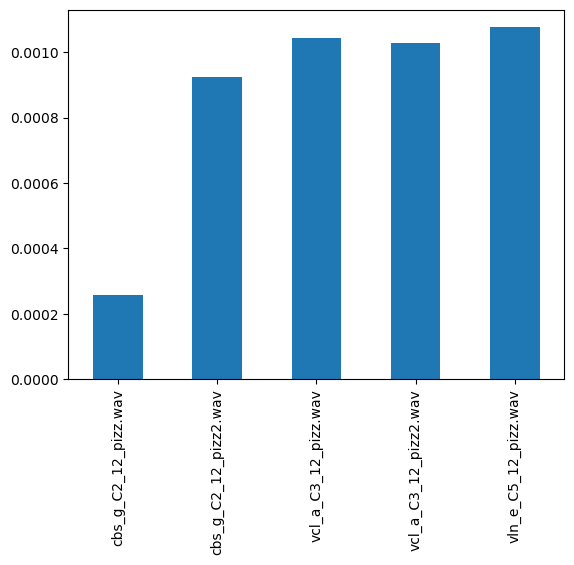

In [814]:
cols_to_plot = []
for x in soundDescriptorsDf.columns:
    if("pizz" in x):
        cols_to_plot.append(x)

print(cols_to_plot)

#seaborn.pairplot(soundDescriptorsDf.iloc[1:], vars=cols_to_plot)

for row1 in range(0, 15):
    print(row1)
    soundDescriptorsDf[cols_to_plot].iloc[row1].plot(kind='bar')
    plt.show()

['acc_qu_G2_12.wav', 'acc_qu_G3_12.wav', 'acc_qu_G4_12.wav', 'acc_qu_G5_1.wav', 'acc_se_G0_12.wav', 'acc_se_G1_12.wav', 'acc_se_G2_12.wav', 'acc_se_G3_12.wav', 'acc_se_G4_12.wav', 'cbs_d_G1_12.wav', 'cbs_d_G2_12.wav', 'cbs_g_G1_12.wav', 'cbs_g_G2_12.wav', 'cbs_g_G3_12.wav', 'clr_G2_12.wav', 'clr_G3_12.wav', 'clr_G4_12.wav', 'clr_G5_12.wav', 'flt_G3_12.wav', 'flt_G4_12.wav', 'flt_G5_12.wav', 'gui_a_G2_12.wav', 'gui_b_G3_12.wav', 'gui_d_G2_12.wav', 'gui_d_G3_12.wav', 'gui_el_G1_12.wav', 'gui_el_G2_12.wav', 'gui_e_G3_12.wav', 'gui_e_G4_12.wav', 'gui_g_G2_12.wav', 'gui_g_G3_12.wav', 'hrp_G0_12.wav', 'hrp_G1_12.wav', 'hrp_G2_12.wav', 'hrp_G3_12.wav', 'hrp_G4_12.wav', 'hrp_G5_12.wav', 'hrp_G6_12.wav', 'sax_G2_12.wav', 'sax_G3_12.wav', 'sax_G4_12.wav', 'trb_G1_12.wav', 'trb_G2_12.wav', 'trb_G3_12.wav', 'trp_G2_12.wav', 'trp_G3_12.wav', 'trp_G4_12.wav', 'tub_G0_12.wav', 'tub_G1_12.wav', 'vcl_a_G3_12.wav', 'vcl_a_G4_12.wav', 'vcl_c_G1_12.wav', 'vcl_c_G2_12.wav', 'vcl_d_G2_12.wav', 'vcl_d_G3_12.

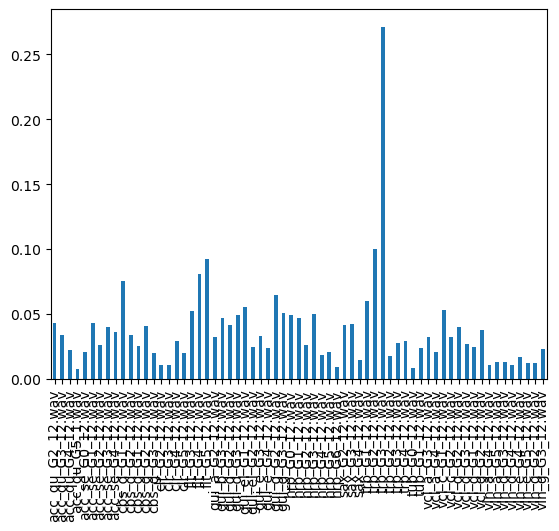

1


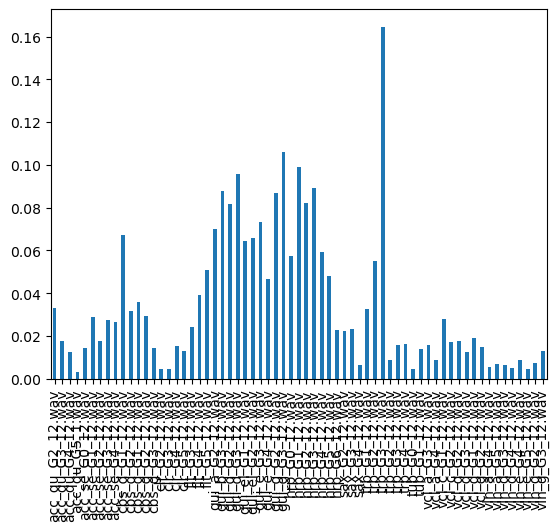

2


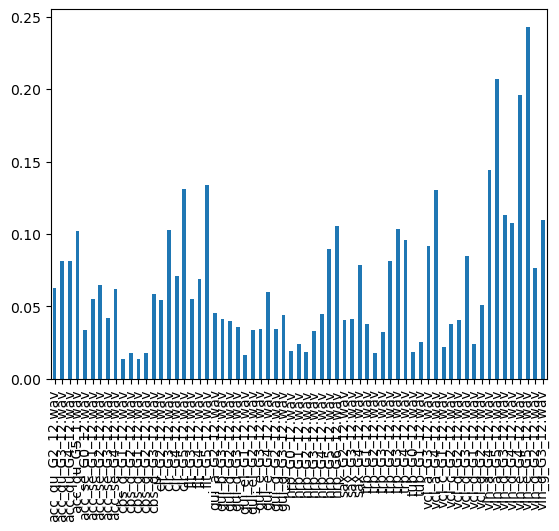

3


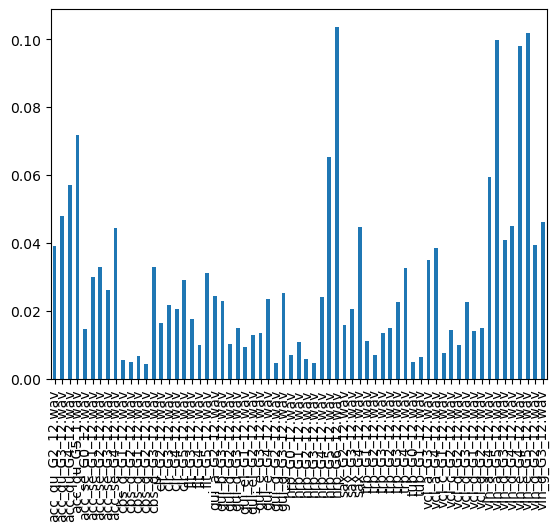

4


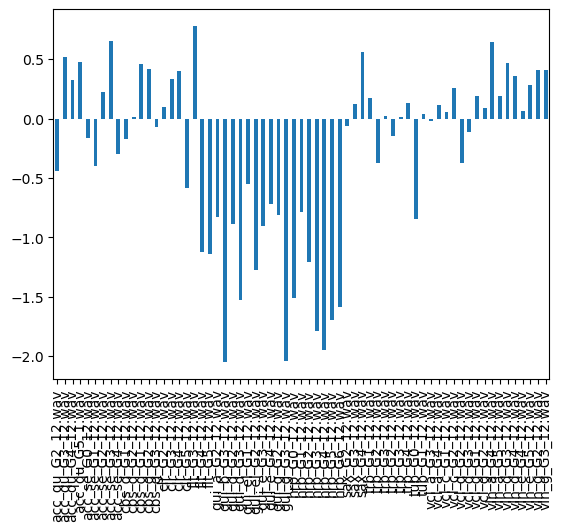

5


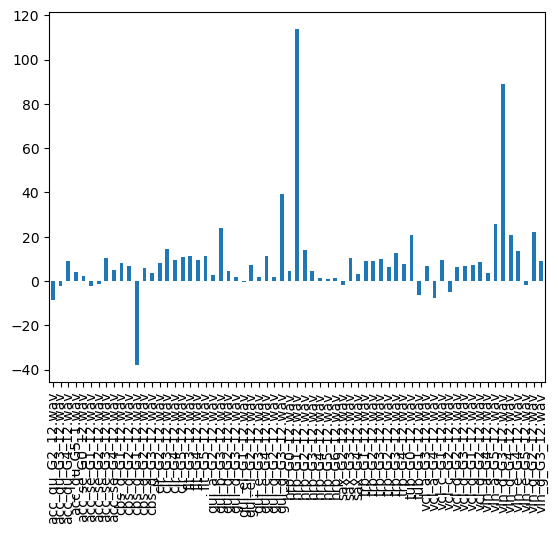

6


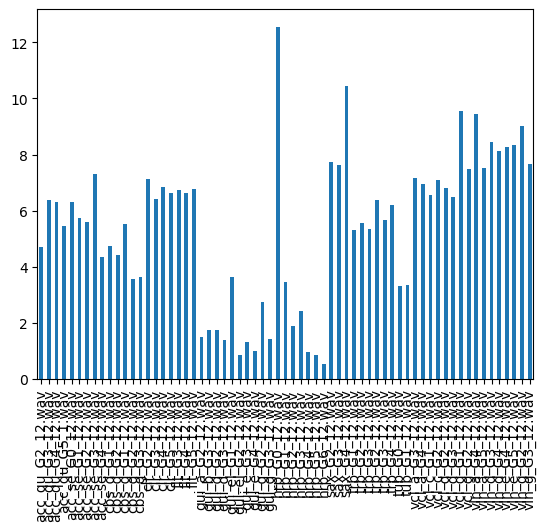

7


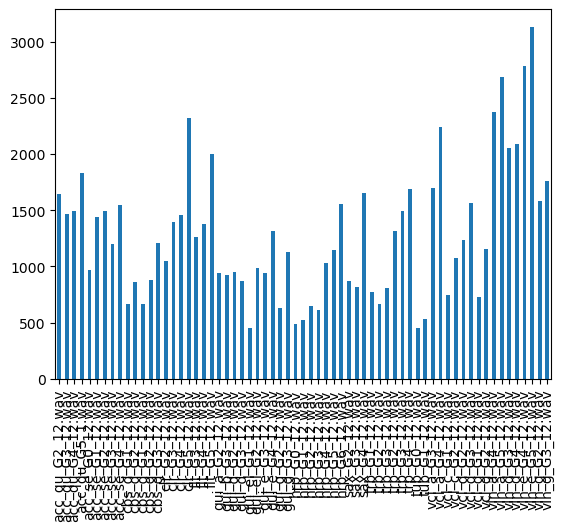

8


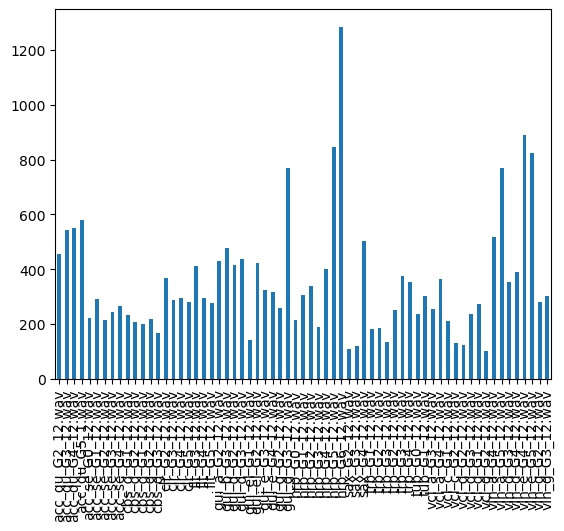

9


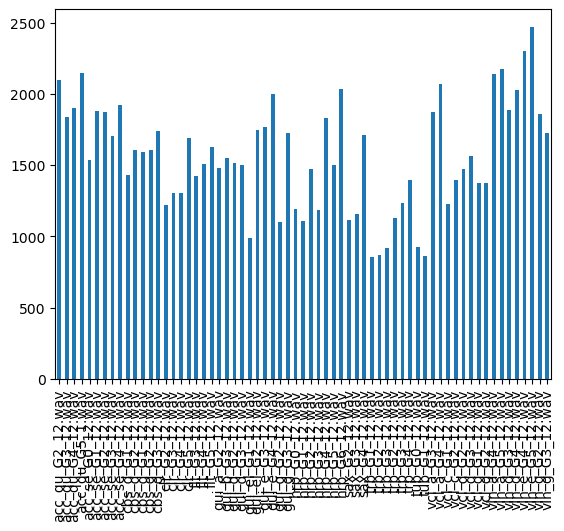

10


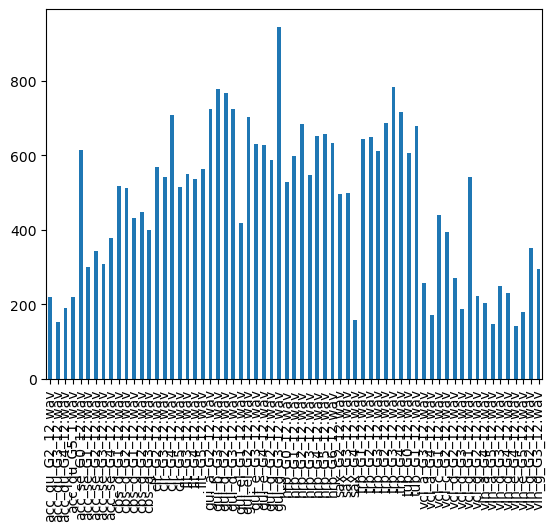

11


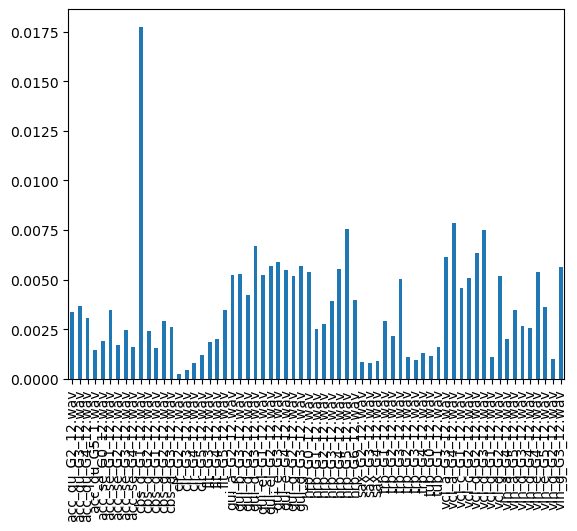

12


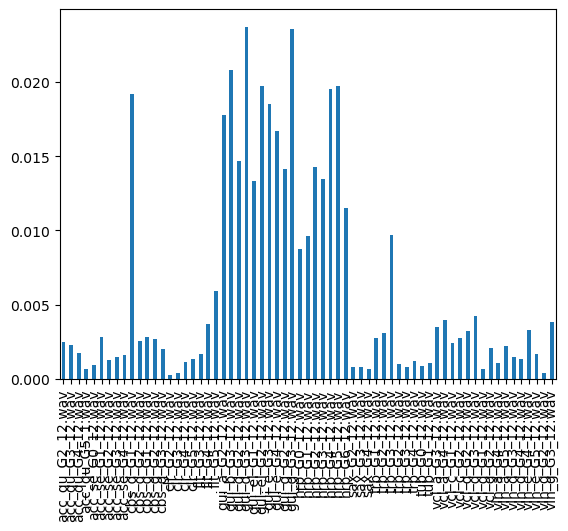

13


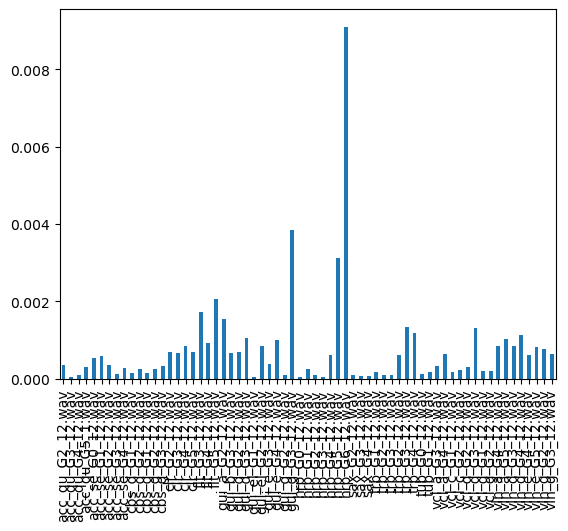

14


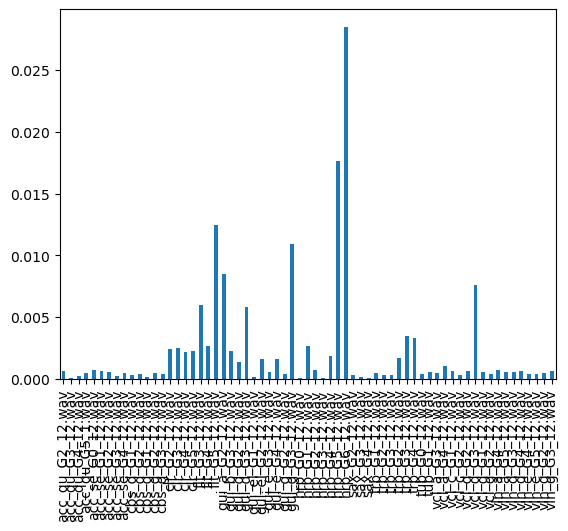

In [815]:
cols_to_plot = []
for x in soundDescriptorsDf.columns:
    if("pizz" not in x ):
        cols_to_plot.append(x)

print(cols_to_plot)

#seaborn.pairplot(soundDescriptorsDf.iloc[1:], vars=cols_to_plot)

for row1 in range(0, 15):
    print(row1)
    soundDescriptorsDf[cols_to_plot].iloc[row1].plot(kind='bar')
    plt.show()

In [816]:
def detect_percursive(filename):
    fileVal, fileRate = librosa.load(filename)
    lat = log_attack_time(fileVal, fileRate, start=0.01, end=0.99)
    ed= effective_duration(fileVal, fileRate, threshold=0.05)

    tc = temporal_centroid(fileVal, fileRate)

    spec_cent = librosa.feature.spectral_centroid(y=fileVal, sr=fileRate)
    spec_cent_std = np.std(spec_cent)

    spec_bw = librosa.feature.spectral_bandwidth(y=fileVal, sr=fileRate)
    spec_bw_average = np.average(spec_bw)

    spec_flux = spectral_flux(fileVal)
    spec_flux_std = np.std(spec_flux)

    if(lat < -1 and ed < 3 and spec_flux_std > 0.003 and tc < 13 and spec_cent_std < 500 and spec_bw_average > 1450):
        #print("Percursive")
        return 0
    else:
        #print("Non percursive")
        return 1

confusionMatrix = [[0, 0], [0, 0]]
for file in allFiles:
    file = os.path.join('.', 'data','sounds', file)
    isPizz = False
    if("pizz" in file):
        isPizz = True
    
    prediction = detect_percursive(file)

    if(prediction == 0 and isPizz):
        confusionMatrix[0][0] += 1
    elif(prediction == 0 and not isPizz):
        confusionMatrix[0][1] += 1
        print("pred pos really neg " + file)
    elif(prediction == 1 and isPizz):
        confusionMatrix[1][0] += 1
        print("pred neg really pos " + file)
    elif(prediction == 1 and not isPizz):
        confusionMatrix[1][1] += 1



pred pos really neg .\data\sounds\gui_d_G3_12.wav
pred pos really neg .\data\sounds\gui_el_G2_12.wav
pred pos really neg .\data\sounds\hrp_G4_12.wav


In [817]:
print(confusionMatrix)
TP = confusionMatrix[0][0]
FP = confusionMatrix[0][1]
FN = confusionMatrix[1][0]
TN = confusionMatrix[1][1]
AccuracyScore = (TP+TN)/ (TP+FN+TN+FP)
print("Accuracy " + str(AccuracyScore))
precision = TP/(TP+FP)
print("Precision " + str(precision))
recall = TP/(TP + FN)
print("Recall " + str(recall))
f1Score = 2 * (precision * recall) / (precision + recall)
print("F1 Score " + str(f1Score))

[[5, 3], [0, 62]]
Accuracy 0.9571428571428572
Precision 0.625
Recall 1.0
F1 Score 0.7692307692307693


Implement the type of excitation classifiers with simple rules (i.e. without any machine-learning algorithm): *percussive* vs *non-percussive*. These are found by the existence of `pizz` on the filename

This is a **binary** classification, as there are only two types of excitation: percussive or non-percussive.

Present the classification results in terms of: 
* accuracy
* precision 
* recall
* F1-Score
* Confusion Matrix

In [820]:
def detect_instrument(filename):
    fileVal, fileRate = librosa.load(filename)
    lat = log_attack_time(fileVal, fileRate, start=0.01, end=0.99)
    ed= effective_duration(fileVal, fileRate, threshold=0.05)

    tc = temporal_centroid(fileVal, fileRate)

    spec_cent = librosa.feature.spectral_centroid(y=fileVal, sr=fileRate)
    spec_cent_std = np.std(spec_cent)

    spec_bw = librosa.feature.spectral_bandwidth(y=fileVal, sr=fileRate)
    spec_bw_average = np.average(spec_bw)

    spec_flux = spectral_flux(fileVal)
    spec_flux_std = np.std(spec_flux)

    spec_flat = librosa.feature.spectral_flatness(y=fileVal)
    spec_flat_average = np.average(spec_flat)

    if(spec_flat_average > 0.0 and ed < 3 and spec_flux_std > 0.003 and tc < 13 and spec_cent_std < 500 and spec_bw_average > 1450):
        #print("Percursive")
        return 0
    else:
        #print("Non percursive")
        return 1

## Task 5

Try to redo task 4 for the second type of classification: 
* Instrument type: the name of the instrument (e.g. accordion, flute, cello, etc.). The first letters of the filename give the name of the instrument.

Is it possible to solve this problem using such sound descriptors and such rules?


Note: 

One of the difficulties you will find is that this is a **multi-class** type of classification.
However, algorithms that are designed for binary classification can be adapted for use for multi-class problems.

This involves using a strategy of fitting multiple binary classification models for each class vs. all other classes (called one-vs-rest) or one model for each pair of classes (called one-vs-one).

* One-vs-Rest: Fit one binary classification model for each class vs. all other classes.
* One-vs-One: Fit one binary classification model for each pair of classes.

Further Info: https://machinelearningmastery.com/types-of-classification-in-machine-learning/


In [100]:
descriptorsDict = {
    "name": [],
    "type": [],
    "isPizz": [],
    "rmsMean": [],
    "rmsStd": [],
    "rmsMax": [],
    "rmsMin": [],
    "zcrMean": [],
    "zcrStd": [],
    "zcrMax": [],
    "zcrMin": [],
    "lat": [],
    "tc": [],
    "ed": [],
    "specCentMean": [],
    "specCentStd": [],
    "specCentMax": [],
    "specCentMin": [],
    "specBwMean": [],
    "specBwStd": [],
    "specBwMax": [],
    "specBwMin": [],
    "specFluxMean": [],
    "specFluxStd": [],
    "specFluxMax": [],
    "specFluxMin": [],
    "specFlatMean": [],
    "specFlatStd": [],
    "specFlatMax": [],
    "specFlatMin": [],
}

In [101]:
# Get the list of all files and directories
path = "./data/sounds"
allFiles = os.listdir(path)

for fileName in allFiles:
    basic_plots(fileName, descriptorsDict, toPlot=False)

In [102]:
descriptorsDf = pd.DataFrame(descriptorsDict)
display(descriptorsDf)

name type  isPizz   rmsMean    rmsStd    rmsMax    rmsMin  \
0       acc_qu_G2_12.wav  acc   False  0.042789  0.033115  0.079277  0.001706   
1       acc_qu_G3_12.wav  acc   False  0.034023  0.017763  0.053900  0.004143   
2       acc_qu_G4_12.wav  acc   False  0.021993  0.012595  0.039048  0.002943   
3        acc_qu_G5_1.wav  acc   False  0.007301  0.003250  0.011636  0.000696   
4       acc_se_G0_12.wav  acc   False  0.020606  0.014487  0.036627  0.001435   
..                   ...  ...     ...       ...       ...       ...       ...   
65  vln_e_C5_12_pizz.wav  vln    True  0.004351  0.007453  0.028905  0.000589   
66       vln_e_G4_12.wav  vln   False  0.016796  0.008660  0.030568  0.001075   
67       vln_e_G5_12.wav  vln   False  0.011841  0.004623  0.018628  0.001189   
68       vln_g_G2_12.wav  vln   False  0.011998  0.007344  0.020952  0.001021   
69       vln_g_G3_12.wav  vln   False  0.023107  0.012757  0.042619  0.000481   

     zcrMean    zcrStd    zcrMax  ...    specBwMax    specBwMin specFluxMean  \
0   0.062602  0.038960  0.079277  ...  2876.451575  1408.455125     0.003386   
1   0.081406  0.047808  0.053900  ...  2407.360681  1305.570863     0.003681   
2   0.081148  0.056935  0.039048  ...  2737.121778  1468.110667     0.003089   
3   0.101839  0.071665  0.011636  ...  2968.801527  1860.307382     0.001466   
4   0.033527  0.014773  0.036627  ...  2819.666156   950.663568     0.001918   
..       ...       ...       ...  ...          ...          ...          ...   
65  0.043852  0.029426  0.028905  ...  2856.052579  1252.011087     0.002219   
66  0.195860  0.098100  0.030568  ...  2751.958389  1676.254202     0.005403   
67  0.243053  0.101852  0.018628  ...  2862.649400  1835.654976     0.003616   
68  0.076232  0.039348  0.020952  ...  2680.547314  1404.426199     0.001019   
69  0.109820  0.046304  0.042619  ...  2738.813913  1453.438516     0.005644   

    specFluxStd  specFluxMax  specFluxMin  specFlatMean  specFlatStd  \
0      0.002446     0.017660          0.0      0.000365     0.000639   
1      0.002286     0.014811          0.0      0.000054     0.000082   
2      0.001770     0.009524          0.0      0.000098     0.000188   
3      0.000674     0.003978          0.0      0.000309     0.000481   
4      0.000915     0.005343          0.0      0.000532     0.000720   
..          ...          ...          ...           ...          ...   
65     0.004572     0.022820          0.0      0.001262     0.001075   
66     0.003271     0.011349          0.0      0.000618     0.000404   
67     0.001668     0.007815          0.0      0.000829     0.000411   
68     0.000387     0.002621          0.0      0.000770     0.000449   
69     0.003829     0.016471          0.0      0.000639     0.000611   

    specFlatMax  specFlatMin  
0      0.005303     0.000065  
1      0.000660     0.000009  
2      0.001531     0.000013  
3      0.004821     0.000083  
4      0.004520     0.000090  
..          ...          ...  
65     0.007143     0.000075  
66     0.003188     0.000149  
67     0.003309     0.000124  
68     0.004014     0.000181  
69     0.005772     0.000142  

[70 rows x 30 columns]

In [103]:
le = preprocessing.LabelEncoder()
instruments = descriptorsDf['type'].unique()

le.fit(instruments)

descriptorsDf['type'] = le.fit_transform(descriptorsDf['type'])


In [104]:
threshold = 0.2
corr_matrix = descriptorsDf.corr()
corr_matrix = corr_matrix.loc[['type']]
corr_matrix = corr_matrix.loc[:, (abs(corr_matrix) > threshold).any()]
display(corr_matrix.head())
columns = corr_matrix.columns

C:\Users\mpspm\AppData\Local\Temp\ipykernel_13548\2433843640.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = descriptorsDf.corr()


type    rmsStd    rmsMin   zcrMean    zcrMin        ed  specCentMean  \
type   1.0 -0.234632 -0.278532  0.327921 -0.278532  0.259065      0.293015   

      specBwMin  specFlatMin  
type   0.202607     0.481006

In [105]:
descriptorsDf['type'] = le.inverse_transform(descriptorsDf['type'])

In [106]:
options = ["tub", "vcl", "vln"]
display(descriptorsDf[descriptorsDf['type'].isin(options)])

name type  isPizz   rmsMean    rmsStd    rmsMax  \
49          tub_G0_12.wav  tub   False  0.008691  0.004667  0.015040   
50          tub_G1_12.wav  tub   False  0.023631  0.013870  0.036826   
51   vcl_a_C3_12_pizz.wav  vcl    True  0.003558  0.006690  0.041681   
52  vcl_a_C3_12_pizz2.wav  vcl    True  0.012449  0.022289  0.087913   
53        vcl_a_G3_12.wav  vcl   False  0.031877  0.015839  0.056046   
54        vcl_a_G4_12.wav  vcl   False  0.020440  0.008588  0.034074   
55        vcl_c_G1_12.wav  vcl   False  0.052878  0.027939  0.095233   
56        vcl_c_G2_12.wav  vcl   False  0.032195  0.017295  0.063854   
57        vcl_d_G2_12.wav  vcl   False  0.040193  0.017558  0.075531   
58        vcl_d_G3_12.wav  vcl   False  0.027016  0.012464  0.060570   
59        vcl_g_G1_12.wav  vcl   False  0.024126  0.018922  0.060041   
60        vcl_g_G2_12.wav  vcl   False  0.037248  0.014789  0.063220   
61        vln_a_G4_12.wav  vln   False  0.010467  0.005329  0.020362   
62        vln_a_G5_12.wav  vln   False  0.012576  0.006894  0.021900   
63        vln_d_G3_12.wav  vln   False  0.013138  0.006531  0.022699   
64        vln_d_G4_12.wav  vln   False  0.010298  0.005024  0.019690   
65   vln_e_C5_12_pizz.wav  vln    True  0.004351  0.007453  0.028905   
66        vln_e_G4_12.wav  vln   False  0.016796  0.008660  0.030568   
67        vln_e_G5_12.wav  vln   False  0.011841  0.004623  0.018628   
68        vln_g_G2_12.wav  vln   False  0.011998  0.007344  0.020952   
69        vln_g_G3_12.wav  vln   False  0.023107  0.012757  0.042619   

      rmsMin   zcrMean    zcrStd    zcrMax  ...    specBwMax    specBwMin  \
49  0.000170  0.018830  0.005057  0.015040  ...  2836.129885   522.387171   
50  0.000323  0.025278  0.006472  0.036826  ...  2903.216194   485.493480   
51  0.000464  0.021587  0.006505  0.041681  ...  3089.193133   636.472151   
52  0.000616  0.027310  0.009932  0.087913  ...  2644.230845   605.891140   
53  0.000413  0.091545  0.035005  0.056046  ...  2714.443303  1199.301899   
54  0.001078  0.130592  0.038573  0.034074  ...  2676.808113  1614.679107   
55  0.000452  0.022071  0.007646  0.095233  ...  2900.328063   719.586801   
56  0.000962  0.038124  0.014373  0.063854  ...  2691.954949   982.476802   
57  0.000521  0.040582  0.009883  0.075531  ...  2673.459074  1070.074680   
58  0.000825  0.084831  0.022713  0.060570  ...  2380.814017  1172.647271   
59  0.000533  0.023887  0.014036  0.060041  ...  2917.046020   738.649283   
60  0.000792  0.050627  0.014958  0.063220  ...  2573.324913  1082.763884   
61  0.000822  0.143910  0.059345  0.020362  ...  2886.402011  1624.886802   
62  0.000941  0.206668  0.099707  0.021900  ...  2742.137371  1850.100016   
63  0.000793  0.113047  0.040884  0.022699  ...  2821.325424  1650.617123   
64  0.000739  0.107337  0.045091  0.019690  ...  2898.052143  1662.655033   
65  0.000589  0.043852  0.029426  0.028905  ...  2856.052579  1252.011087   
66  0.001075  0.195860  0.098100  0.030568  ...  2751.958389  1676.254202   
67  0.001189  0.243053  0.101852  0.018628  ...  2862.649400  1835.654976   
68  0.001021  0.076232  0.039348  0.020952  ...  2680.547314  1404.426199   
69  0.000481  0.109820  0.046304  0.042619  ...  2738.813913  1453.438516   

   specFluxMean  specFluxStd  specFluxMax  specFluxMin  specFlatMean  \
49     0.001170     0.000858     0.005112          0.0      0.000113   
50     0.001587     0.001064     0.006871          0.0      0.000168   
51     0.001289     0.003412     0.022705          0.0      0.001019   
52     0.004799     0.010193     0.049804          0.0      0.000954   
53     0.006146     0.003470     0.013397          0.0      0.000328   
54     0.007861     0.003984     0.016417          0.0      0.000645   
55     0.004556     0.002418     0.010083          0.0      0.000180   
56     0.005080     0.002777     0.012521          0.0      0.000228   
57     0.006347     0.003221     0.016164          0.0      0.000312   
58     0.007515     0

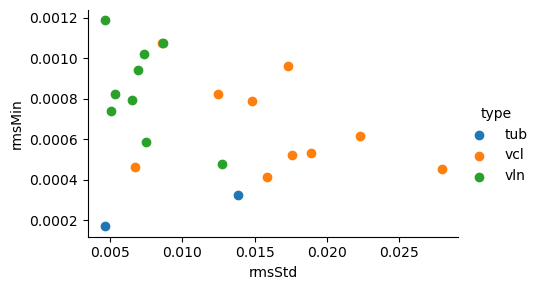

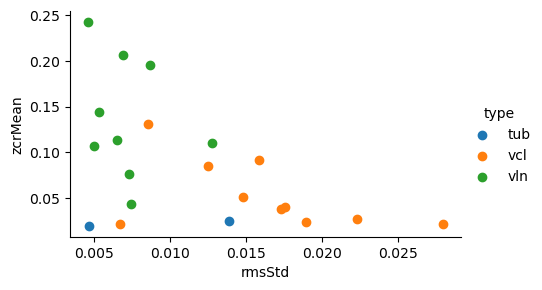

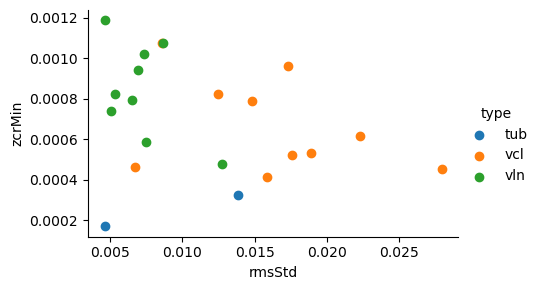

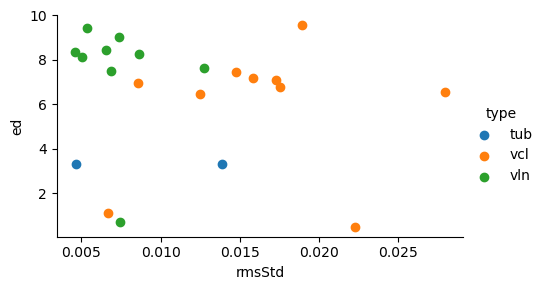

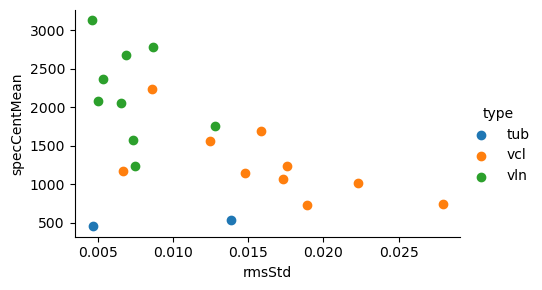

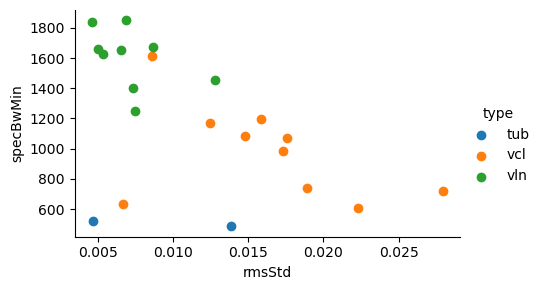

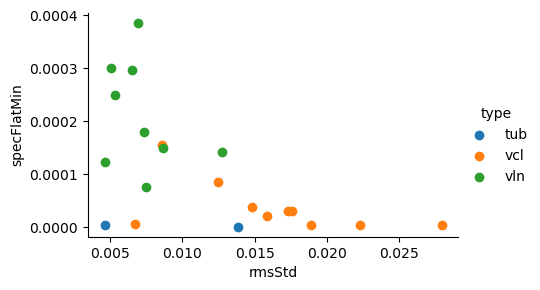

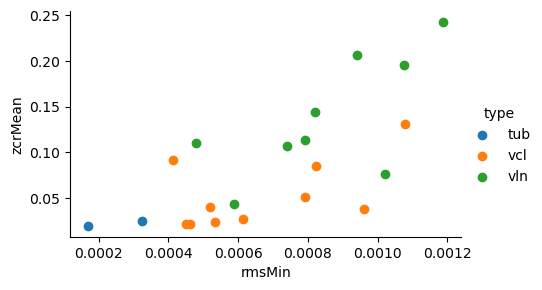

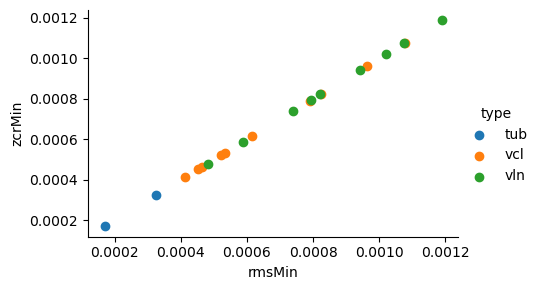

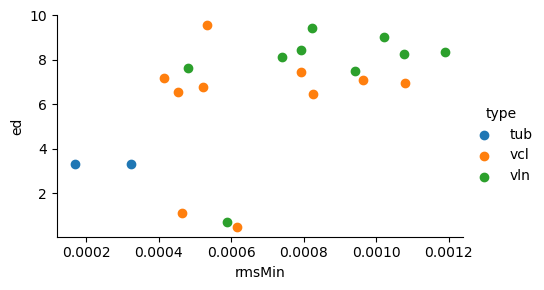

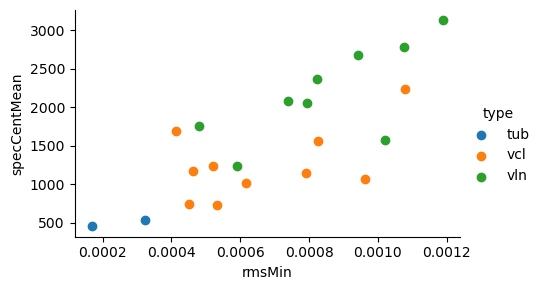

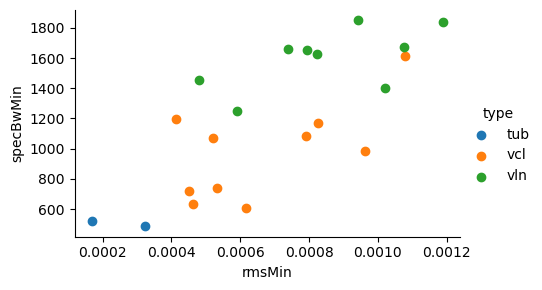

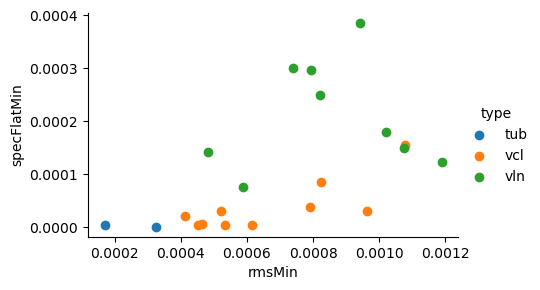

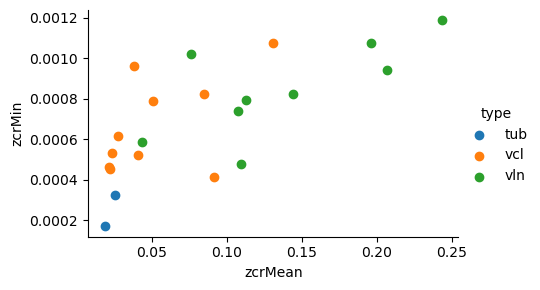

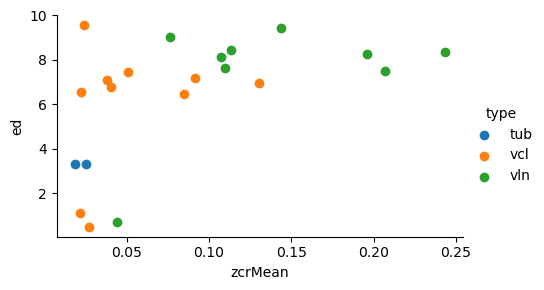

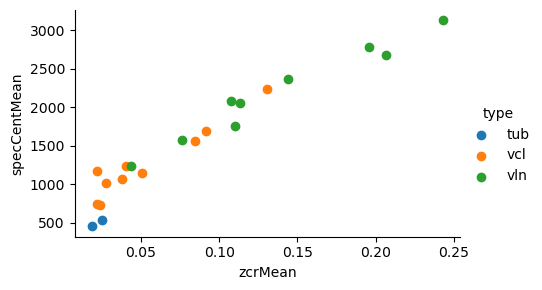

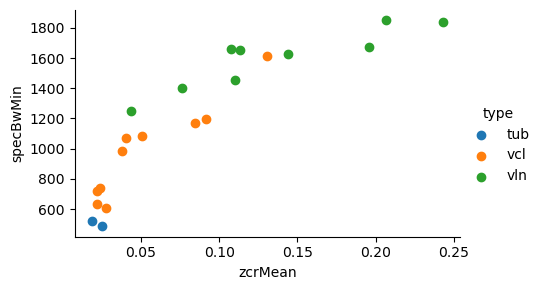

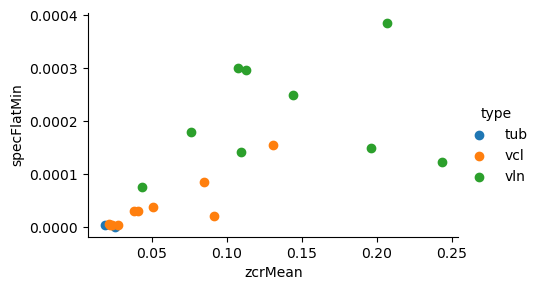

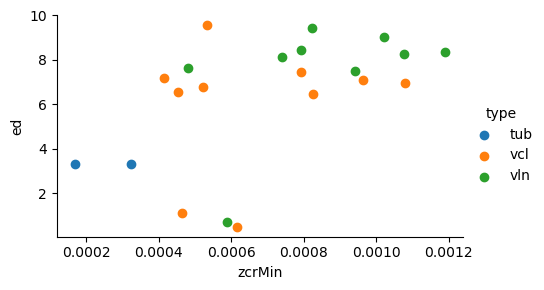

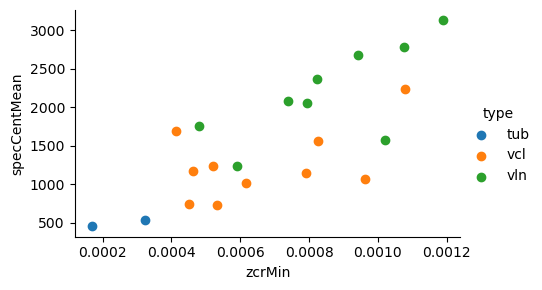

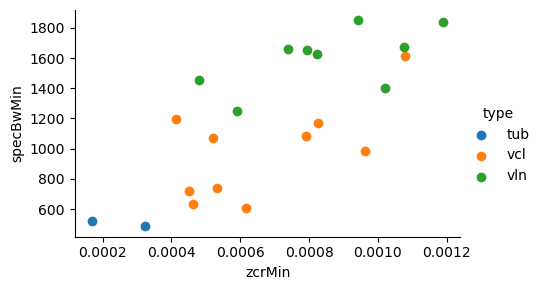

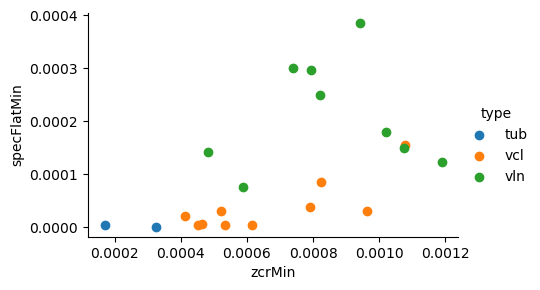

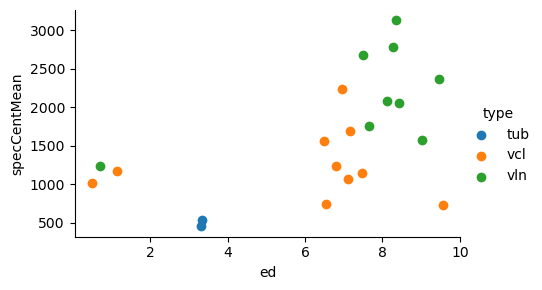

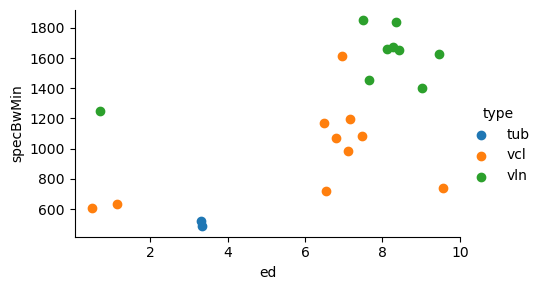

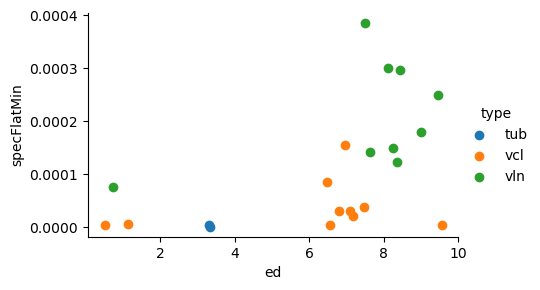

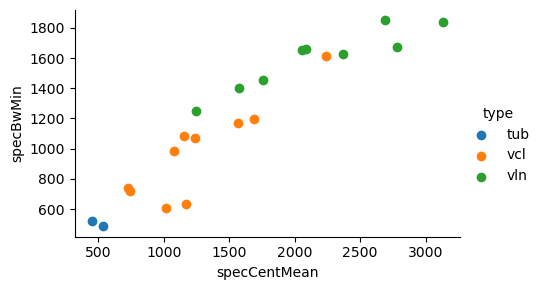

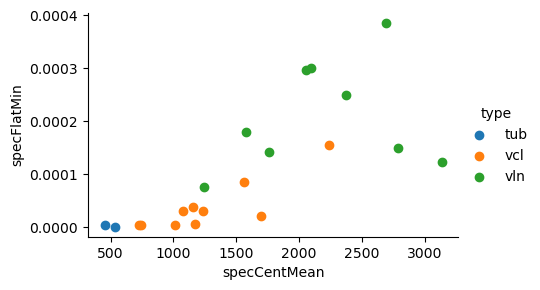

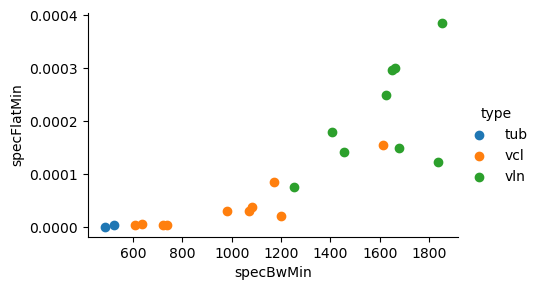

In [107]:
for col1 in range(1, len(columns)-1):
    for col2 in range(col1+1, len(columns)):
        fg = sns.FacetGrid(data=descriptorsDf[descriptorsDf['type'].isin(options)], hue='type', aspect=1.61)
        fg.map(matplotlib.pyplot.scatter, columns[col1], columns[col2]).add_legend()
        plt.show()

In [108]:
def predict_instrument(filename):
    fileVal, fileRate = librosa.load(filename)
    
    ed = effective_duration(fileVal, fileRate, threshold=0.05)

    rms = librosa.feature.rms(y=fileVal)
    zcr = librosa.feature.zero_crossing_rate(fileVal)
    spec_cent = librosa.feature.spectral_centroid(y=fileVal, sr=fileRate)
    spec_bw = librosa.feature.spectral_bandwidth(y=fileVal, sr=fileRate)
    spec_flat = librosa.feature.spectral_flatness(y=fileVal)

    rms_std = np.std(rms)
    rms_min = np.min(rms)

    zcr_average = np.average(zcr)
    zcr_min = np.min(rms)

    spec_cent_average = np.average(spec_cent)

    spec_bw_min = np.min(spec_bw)

    spec_flat_min = np.min(spec_flat)

    if(rms_min >= 0.0012 and (0.009 <= rms_std <= 0.04)):
        #print("acc")
        return "acc"
    elif(0.0005 <= rms_min <= 0.0012 and zcr_average < 0.0025):
        #print("cbs")
        return "cbs"
    elif(rms_min <= 0.00025 and 0.05 <= zcr_average <= 0.145 and 
         1000 <= spec_cent_average <=2450 and 850 <= spec_bw_min <= 1000):
        #print("clr")
        return "clr"
    elif(1200 <= spec_cent_average <= 2450 and 0.02 <= rms_std <= 0.06 and rms_min <= 0.0005):
        #print("flt")
        return "flt"
    elif(0.06 <= rms_std <= 0.11 and 
         0.025 <= zcr_average <= 0.05 and 
         0.0001 <= zcr_min <= 0.0012 and
         750 <= spec_cent_average <= 1300):
        #print("gui")
        return "gui"
    elif(0.04 <= rms_std <= 0.1 and spec_cent_average <= 1200 and 
         spec_bw_min <= 550 and rms_min <= 0.0011 and
         spec_cent_average <= 750):
        #print("hrp")
        return "hrp"
    elif(rms_std <= 0.03 and 0.03 <= zcr_average < 0.05 and ed >= 7 and 
         750 <= spec_cent_average <= 1750 and 600 <= spec_bw_min <= 1150 and
         0.075 <= zcr_average <= 0.12):
        #print("sax")
        return "sax"
    elif(rms_min >= 0.00032 and zcr_average <= 0.04 and zcr_min >= 0.00031 and 
         ed <= 5.6 and spec_cent_average <= 800 and spec_bw_min <= 530 and zcr_average <= 0.04):
        #print("trb")
        return "trb"
    elif(rms_std < 0.025 and rms_min <=0.0001 and zcr_average >= 0.08 
         and zcr_min <= 0.0001 and spec_cent_average >= 1300 and spec_bw_min > 700):
        #print("trp")
        return "trp"
    elif(zcr_average < 0.05 and zcr_min < 0.0004 and 3 < ed < 4 and spec_cent_average < 550
         and spec_bw_min < 600 and spec_flat_min < 0.00002):
        #print("tub")
        return "tub"
    elif(ed > 6 and rms_std > 0.0075 and spec_flat_min <= 0.0001 and zcr_average <= 0.10 
         and rms_min > 0.0004 and zcr_min > 0.0004):
        #print("vcl")
        return "vcl"
    else:
        return "vln"



In [109]:

confusionMatrix = [[0 for _ in range(12)] for _ in range(12)]
values = ["acc", "cbs", "clr", "flt", "gui", "hrp", "sax", "trb", "trp", "tub", "vcl", "vln"]

In [117]:
display(descriptorsDf)

name type  isPizz   rmsMean    rmsStd    rmsMax    rmsMin  \
0       acc_qu_G2_12.wav  acc   False  0.042789  0.033115  0.079277  0.001706   
1       acc_qu_G3_12.wav  acc   False  0.034023  0.017763  0.053900  0.004143   
2       acc_qu_G4_12.wav  acc   False  0.021993  0.012595  0.039048  0.002943   
3        acc_qu_G5_1.wav  acc   False  0.007301  0.003250  0.011636  0.000696   
4       acc_se_G0_12.wav  acc   False  0.020606  0.014487  0.036627  0.001435   
..                   ...  ...     ...       ...       ...       ...       ...   
65  vln_e_C5_12_pizz.wav  vln    True  0.004351  0.007453  0.028905  0.000589   
66       vln_e_G4_12.wav  vln   False  0.016796  0.008660  0.030568  0.001075   
67       vln_e_G5_12.wav  vln   False  0.011841  0.004623  0.018628  0.001189   
68       vln_g_G2_12.wav  vln   False  0.011998  0.007344  0.020952  0.001021   
69       vln_g_G3_12.wav  vln   False  0.023107  0.012757  0.042619  0.000481   

     zcrMean    zcrStd    zcrMax  ...    specBwMax    specBwMin specFluxMean  \
0   0.062602  0.038960  0.079277  ...  2876.451575  1408.455125     0.003386   
1   0.081406  0.047808  0.053900  ...  2407.360681  1305.570863     0.003681   
2   0.081148  0.056935  0.039048  ...  2737.121778  1468.110667     0.003089   
3   0.101839  0.071665  0.011636  ...  2968.801527  1860.307382     0.001466   
4   0.033527  0.014773  0.036627  ...  2819.666156   950.663568     0.001918   
..       ...       ...       ...  ...          ...          ...          ...   
65  0.043852  0.029426  0.028905  ...  2856.052579  1252.011087     0.002219   
66  0.195860  0.098100  0.030568  ...  2751.958389  1676.254202     0.005403   
67  0.243053  0.101852  0.018628  ...  2862.649400  1835.654976     0.003616   
68  0.076232  0.039348  0.020952  ...  2680.547314  1404.426199     0.001019   
69  0.109820  0.046304  0.042619  ...  2738.813913  1453.438516     0.005644   

    specFluxStd  specFluxMax  specFluxMin  specFlatMean  specFlatStd  \
0      0.002446     0.017660          0.0      0.000365     0.000639   
1      0.002286     0.014811          0.0      0.000054     0.000082   
2      0.001770     0.009524          0.0      0.000098     0.000188   
3      0.000674     0.003978          0.0      0.000309     0.000481   
4      0.000915     0.005343          0.0      0.000532     0.000720   
..          ...          ...          ...           ...          ...   
65     0.004572     0.022820          0.0      0.001262     0.001075   
66     0.003271     0.011349          0.0      0.000618     0.000404   
67     0.001668     0.007815          0.0      0.000829     0.000411   
68     0.000387     0.002621          0.0      0.000770     0.000449   
69     0.003829     0.016471          0.0      0.000639     0.000611   

    specFlatMax  specFlatMin  
0      0.005303     0.000065  
1      0.000660     0.000009  
2      0.001531     0.000013  
3      0.004821     0.000083  
4      0.004520     0.000090  
..          ...          ...  
65     0.007143     0.000075  
66     0.003188     0.000149  
67     0.003309     0.000124  
68     0.004014     0.000181  
69     0.005772     0.000142  

[70 rows x 30 columns]

In [125]:
for file in allFiles:
    filename = os.path.join('.', 'data','sounds', file)
    
    prediction = predict_instrument(filename)
    trueType = descriptorsDf[descriptorsDf['name'] == file].values[0][1]
    print(trueType , prediction)
    if(prediction == trueType):
        confusionMatrix[values.index(trueType)][values.index(prediction)] += 1
    else:
        confusionMatrix[values.index(trueType)][values.index(prediction)] += 1


acc acc
acc acc
acc acc
acc vln
acc acc
acc acc
acc acc
acc acc
acc acc
cbs vln
cbs vln
cbs vln
cbs hrp
cbs vln
cbs vln
cbs vln
clr clr
clr clr
clr vln
clr clr
flt clr
flt flt
flt flt
gui gui
gui gui
gui gui
gui gui
gui trb
gui gui
gui gui
gui vln
gui hrp
gui gui
hrp vcl
hrp hrp
hrp hrp
hrp hrp
hrp vln
hrp vln
hrp clr
sax vcl
sax vcl
sax vln
trb trb
trb hrp
trb vln
trp trp
trp trp
trp clr
tub tub
tub trb
vcl vln
vcl vln
vcl vcl
vcl vln
vcl vcl
vcl vcl
vcl vcl
vcl vcl
vcl vcl
vcl vcl
vln vln
vln vln
vln vln
vln vln
vln vln
vln vln
vln vln
vln vln
vln vln


In [130]:
print("    ", end = "")
for i in values:
    print(i, end=" ")
print()
for i, line in enumerate(confusionMatrix):
    print(values[i], end= " ")
    print(line)

    acc cbs clr flt gui hrp sax trb trp tub vcl vln 
acc [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
cbs [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 6]
clr [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1]
flt [0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0]
gui [0, 0, 0, 0, 7, 1, 0, 1, 0, 0, 0, 1]
hrp [0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 2]
sax [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1]
trb [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]
trp [0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0]
tub [8, 0, 6, 2, 7, 6, 0, 4, 2, 2, 10, 25]
vcl [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 3]
vln [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9]


## Task 6

### Machine Learning

Can you solve tasks 4-6 using Machine Learning?
If so, show me and comment your results.

#### Task 4 with machine learning

In [821]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

for key in soundDescriptors:
    soundDescriptors[key].append(key[0:3])
soundDescriptorsDf = pd.DataFrame.from_dict(soundDescriptors, orient='index')

scaled_df = pd.DataFrame(soundDescriptorsDf)
scaled_df.style

In [822]:
x = scaled_df.loc[:, 2:15]
y = scaled_df.loc[:, 0]
print(y)
print("--------")
print(x)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=3)
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier( 
    criterion='gini', 
    splitter='best', 
    max_depth=20, 
    min_samples_split=10, 
    min_samples_leaf=6, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None, 
    ccp_alpha=0.0
)
clf.fit(X_train, y_train)

acc_qu_G2_12.wav        False
acc_qu_G3_12.wav        False
acc_qu_G4_12.wav        False
acc_qu_G5_1.wav         False
acc_se_G0_12.wav        False
                        ...  
vln_e_C5_12_pizz.wav     True
vln_e_G4_12.wav         False
vln_e_G5_12.wav         False
vln_g_G2_12.wav         False
vln_g_G3_12.wav         False
Name: 0, Length: 70, dtype: bool
--------
                            2         3         4         5           6   \
acc_qu_G2_12.wav      0.033115  0.062602  0.038960 -0.437343   -8.759839   
acc_qu_G3_12.wav      0.017763  0.081406  0.047808  0.518609  -2.3784723   
acc_qu_G4_12.wav      0.012595  0.081148  0.056935  0.320650    9.146079   
acc_qu_G5_1.wav       0.003250  0.101839  0.071665  0.479609   4.2871737   
acc_se_G0_12.wav      0.014487  0.033527  0.014773 -0.161308   2.2002966   
...                        ...       ...       ...       ...         ...   
vln_e_C5_12_pizz.wav  0.007453  0.043852  0.029426 -1.480086  0.54409206   
vln_e_G4_12.wav     

DecisionTreeClassifier(max_depth=20, min_samples_leaf=6, min_samples_split=10)

In [823]:
y_pred = forest.predict(X_test)
print("Accuracy RF:", accuracy_score(y_test, y_pred))
precision = precision_score(y_test, y_pred, average='micro')
print('Precision RF: %.3f' % precision)
recall = recall_score(y_test, y_pred, average='micro')
print('Recall RF: %.3f' % recall)
score = f1_score(y_test, y_pred, average='micro')
print('F-Measure RF: %.3f' % score)
confusionMatrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix RF:', confusionMatrix)
print("---------------------------------------")
predictions = clf.predict(X_test)
print("Accuracy DT:", accuracy_score(y_test, predictions))
precision = precision_score(y_test, predictions, average='micro')
print('Precision DT: %.3f' % precision)
recall = recall_score(y_test, predictions, average='micro')
print('Recall DT: %.3f' % recall)
score = f1_score(y_test, predictions, average='micro')
print('F-Measure DT: %.3f' % score)
confusionMatrix = confusion_matrix(y_test, predictions)
print('Confusion Matrix DT:', confusionMatrix)

Accuracy RF: 0.8571428571428571
Precision RF: 0.857
Recall RF: 0.857
F-Measure RF: 0.857
Confusion Matrix RF: [[12  0]
 [ 2  0]]
---------------------------------------
Accuracy DT: 0.8571428571428571
Precision DT: 0.857
Recall DT: 0.857
F-Measure DT: 0.857
Confusion Matrix DT: [[12  0]
 [ 2  0]]


#### Task 5 with machine learning

In [824]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

soundDescriptorsDf = pd.DataFrame.from_dict(soundDescriptors, orient='index')

scaled_df = pd.DataFrame(soundDescriptorsDf)
scaled_df.style

In [825]:
x = scaled_df.loc[:, 1:15]
y = scaled_df.loc[:, 16]
print(y)
print("--------")
print(x)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=3)
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier( 
    criterion='gini', 
    splitter='best', 
    max_depth=20, 
    min_samples_split=10, 
    min_samples_leaf=6, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None, 
    ccp_alpha=0.0
)
clf.fit(X_train, y_train)

acc_qu_G2_12.wav        acc
acc_qu_G3_12.wav        acc
acc_qu_G4_12.wav        acc
acc_qu_G5_1.wav         acc
acc_se_G0_12.wav        acc
                       ... 
vln_e_C5_12_pizz.wav    vln
vln_e_G4_12.wav         vln
vln_e_G5_12.wav         vln
vln_g_G2_12.wav         vln
vln_g_G3_12.wav         vln
Name: 16, Length: 70, dtype: object
--------
                            1         2         3         4         5   \
acc_qu_G2_12.wav      0.042789  0.033115  0.062602  0.038960 -0.437343   
acc_qu_G3_12.wav      0.034023  0.017763  0.081406  0.047808  0.518609   
acc_qu_G4_12.wav      0.021993  0.012595  0.081148  0.056935  0.320650   
acc_qu_G5_1.wav       0.007301  0.003250  0.101839  0.071665  0.479609   
acc_se_G0_12.wav      0.020606  0.014487  0.033527  0.014773 -0.161308   
...                        ...       ...       ...       ...       ...   
vln_e_C5_12_pizz.wav  0.004351  0.007453  0.043852  0.029426 -1.480086   
vln_e_G4_12.wav       0.016796  0.008660  0.195860  0.0

DecisionTreeClassifier(max_depth=20, min_samples_leaf=6, min_samples_split=10)

In [826]:
y_pred = forest.predict(X_test)
print("Accuracy RF:", accuracy_score(y_test, y_pred))
precision = precision_score(y_test, y_pred, average='micro')
print('Precision RF: %.3f' % precision)
recall = recall_score(y_test, y_pred, average='micro')
print('Recall RF: %.3f' % recall)
score = f1_score(y_test, y_pred, average='micro')
print('F-Measure RF: %.3f' % score)
confusionMatrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix RF:', confusionMatrix)
print("---------------------------------------")
predictions = clf.predict(X_test)
print("Accuracy DT:", accuracy_score(y_test, predictions))
precision = precision_score(y_test, predictions, average='micro')
print('Precision DT: %.3f' % precision)
recall = recall_score(y_test, predictions, average='micro')
print('Recall DT: %.3f' % recall)
score = f1_score(y_test, predictions, average='micro')
print('F-Measure DT: %.3f' % score)
confusionMatrix = confusion_matrix(y_test, predictions)
print('Confusion Matrix DT:', confusionMatrix)

Accuracy RF: 0.42857142857142855
Precision RF: 0.429
Recall RF: 0.429
F-Measure RF: 0.429
Confusion Matrix RF: [[2 0 0 0 0 1 0]
 [0 1 1 1 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 0 2]]
---------------------------------------
Accuracy DT: 0.42857142857142855
Precision DT: 0.429
Recall DT: 0.429
F-Measure DT: 0.429
Confusion Matrix DT: [[2 1 0 0 0 0 0]
 [0 1 1 1 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 1 0 0 0 1 0]
 [0 0 0 0 0 0 2]]
